# Bearing Fault Diagnosis

### Load necessary packages and libraries 

In [1]:
import os
import scipy.io 
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    log_loss,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    balanced_accuracy_score
)
import tensorflow as tf
from keras import layers, models
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model

### Import Data  

In [2]:
folder_path1 = os.path.join(os.getcwd(), 'CWRU_data', '2HP')
folder_path2 = os.path.join(os.getcwd(), 'CWRU_data', '3HP')

def load_cwru_data(folder_path = folder_path1):
    """
    Load CWRU bearing data from .mat files into a DataFrame.

    Args:
        folder_path (str): Path to the dataset folder.

    Returns:
        pd.DataFrame: DataFrame with columns for condition, fault size, label, and signal.
    """
    data_dict = {
        'Condition': [],
        'Fault Size (mm)': [],
        'Fault Label': [],
        'Signal': []
    }

    # Define file mappings: (file_id, condition, fault_size, fault_label)
    file_mappings_2HP = [
        ('99', 'Normal', 0, 0),
        ('124', 'RE (Rolling element)', 0.18, 1),
        ('111', 'IR (Inner ring)', 0.18, 2),
        ('137', 'OR (Outer ring)', 0.18, 3),
        ('191', 'RE (Rolling element)', 0.36, 4),
        ('176', 'IR (Inner ring)', 0.36, 5),
        ('203', 'OR (Outer ring)', 0.36, 6),
        ('228', 'RE (Rolling element)', 0.54, 7),
        ('215', 'IR (Inner ring)', 0.54, 8),
        ('240', 'OR (Outer ring)', 0.54, 9)
    ]
    # file_mappings_3HP = [
    #     ('100', 'Normal', 0, 0),
    #     ('125', 'RE (Rolling element)', 0.18, 1),
    #     ('112', 'IR (Inner ring)', 0.18, 2),
    #     ('138', 'OR (Outer ring)', 0.18, 3),
    #     ('192', 'RE (Rolling element)', 0.36, 4),
    #     ('177', 'IR (Inner ring)', 0.36, 5),
    #     ('204', 'OR (Outer ring)', 0.36, 6),
    #     ('229', 'RE (Rolling element)', 0.54, 7),
    #     ('217', 'IR (Inner ring)', 0.54, 8),
    #     ('241', 'OR (Outer ring)', 0.54, 9)
    # ]

    for file_id, condition, fault_size, fault_label in file_mappings_2HP:
    # for file_id, condition, fault_size, fault_label in file_mappings_3HP:
        file_path = os.path.join(folder_path, f'{file_id}.mat')
        if file_id == '99':
            signal = scipy.io.loadmat(file_path)[f'X0{file_id}_DE_time'].flatten()
        else:
            signal = scipy.io.loadmat(file_path)[f'X{file_id}_DE_time'].flatten()
        data_dict['Condition'].append(condition)
        data_dict['Fault Size (mm)'].append(fault_size)
        data_dict['Fault Label'].append(fault_label)
        data_dict['Signal'].append(signal)

    return pd.DataFrame(data_dict)

df = load_cwru_data(folder_path=folder_path1)


# Function to preprocess data for imbalance with different points for each label
def preprocess_data_for_imbalance(df, start_point_dict, num_points_dict):
    """
    Preprocess data by selecting a section of the signal for each fault label
    based on a given start point and number of points for each label.

    Args:
        df (pd.DataFrame): Input DataFrame containing signals and labels.
        start_point_dict (dict): Dictionary specifying the start point for each label.
        num_points_dict (dict): Dictionary specifying the number of points for each label.

    Returns:
        pd.DataFrame: Processed DataFrame with signals for each label.
    """
    processed_data = {
        'Condition': [],
        'Fault Size (mm)': [],
        'Fault Label': [],
        'Signal': []
    }

    for fault_label in df['Fault Label'].unique():
        subset = df[df['Fault Label'] == fault_label]
        if subset.empty:
            continue

        signal = subset.iloc[0]['Signal']
        condition = subset.iloc[0]['Condition']
        fault_size = subset.iloc[0]['Fault Size (mm)']

        # Get start point and number of points for the current label
        start_point = start_point_dict.get(fault_label, 0)  # Default start_point is 0
        num_points = num_points_dict.get(fault_label, len(signal))  # Default is full signal length

        # Validate range
        if start_point >= len(signal):
            print(f"Start point {start_point} is out of range for signal with length {len(signal)}. Skipping Fault Label {fault_label}.")
            continue

        end_point = min(start_point + num_points, len(signal))
        signal_section = signal[start_point:end_point]

        # Append to processed data
        processed_data['Condition'].append(condition)
        processed_data['Fault Size (mm)'].append(fault_size)
        processed_data['Fault Label'].append(fault_label)
        processed_data['Signal'].append(signal_section)

    return pd.DataFrame(processed_data)

# All classes start at index 0
start_point_dict_train = {label: 0 for label in range(10)}

# Imbalanced case: IR ratio = 50:1 for normal (class 0) vs. faults (classes 1–9)
num_points_dict_train = {0: 480000, **{label: 9600 for label in range(1, 10)}}


# Preprocess data and save to df_imbalance
df_imbalance_train = preprocess_data_for_imbalance(df, start_point_dict_train, num_points_dict_train)


# Function to preprocess data for imbalance with different points for each label

# Sampling function
def sampling(data, interval_length, samples_per_block, ignore_points=0):
    """
    Split signal data into blocks with specified intervals and block size.
    
    Args:
        data (np.array): Input signal data.
        interval_length (int): Step size for sampling.
        samples_per_block (int): Number of samples per block.
        ignore_points (int): Number of points to ignore at the start and end.
    
    Returns:
        np.array: Split data blocks.
    """
    adjusted_length = len(data) - 2 * ignore_points
    num_blocks = (
        round(adjusted_length / interval_length) - round(samples_per_block / interval_length) - 1
    )
    split_data = np.zeros([num_blocks, samples_per_block])

    for i in range(num_blocks):
        start_idx = ignore_points + i * interval_length
        split_data[i, :] = data[start_idx:(start_idx + samples_per_block)].T

    return split_data


def data_preparation(data, interval_length, samples_per_block):
    """
    Prepare data by splitting and labeling for multi-class classification.
    
    Args:
        data (list): List of signal data for all classes.
        interval_length (int): Step size for sampling.
        samples_per_block (int): Number of samples per block.
    
    Returns:
        tuple: Prepared data (X), positional labels (y_positional), and class labels (y_class).
    """
    for count, signal in enumerate(data):
        split_data = sampling(signal, interval_length, samples_per_block)
        y = np.zeros([len(split_data), 10])  # One-hot encoding
        y[:, count] = 1
        y_class = np.zeros([len(split_data), 1])
        y_class[:, 0] = count

        if count == 0:
            X = split_data
            y_positional = y
            y_label = y_class
        else:
            X = np.append(X, split_data, axis=0)
            y_positional = np.append(y_positional, y, axis=0)
            y_label = np.append(y_label, y_class, axis=0)

    return X, y_positional, y_label

In [3]:
df_imbalance_train.head(10)

,Condition,Fault Size (mm),Fault Label,Signal
0,Normal,0.00,0,"[0.06425353846153846, 0.06300184615384616, -0...."
1,RE (Rolling element),0.18,1,"[0.09992676923076924, 0.14164984615384615, 0.1..."
2,IR (Inner ring),0.18,2,"[0.06133292307692308, -0.015646153846153844, -..."
3,OR (Outer ring),0.18,3,"[-0.967796, -1.7336026666666666, -2.226056, -2..."
4,RE (Rolling element),0.36,4,"[0.06446215384615385, 0.09575446153846154, 0.1..."
5,IR (Inner ring),0.36,5,"[0.16568133333333332, 0.116436, 0.0626, 0.0171..."
6,OR (Outer ring),0.36,6,"[-0.124752, -0.12913292307692306, -0.132053538..."
7,RE (Rolling element),0.54,7,"[-0.20360861538461536, -0.2953993846153846, -0..."
8,IR (Inner ring),0.54,8,"[-0.3917796923076923, -0.3844781538461538, -0...."
9,OR (Outer ring),0.54,9,"[-0.3447173333333333, -0.4323573333333333, -0...."


### Prepare dataset with overlapping windows

In [4]:
def prepare_datasets(df_imbalance, interval_length, samples_per_block):
    """
    Prepare train or test datasets using the data_preparation function.
    
    Args:
        df_imbalance (pd.DataFrame): DataFrame containing signals and labels.
        interval_length (int): Interval length for sampling.
        samples_per_block (int): Number of samples per block.
    
    Returns:
        tuple: X (input data), y_positional (one-hot labels), y_class (class labels).
    """
    signals = df_imbalance['Signal'].tolist()
    X, y_positional, y_class = data_preparation(signals, interval_length, samples_per_block)
    return X, y_positional, y_class


# Set parameters
interval_length = 320
samples_per_block = 1600


# Prepare train datasets
X, y_positional, y_class = prepare_datasets(df_imbalance_train, interval_length, samples_per_block)

In [5]:
X.shape, y_positional.shape, y_class.shape

((1710, 1600), (1710, 10), (1710, 1))

### Manual Splitting & K-Fold Cross Validation 

In [6]:
def time_series_stratified_split(X, y, train_ratio = 0.8):
    num_classes = y.shape[1]
    X_train, y_train, X_test, y_test = [], [], [], []

    for cls in range(num_classes):
        cls_indices = np.where(np.argmax(y, axis=1) == cls)[0]
        n_train = int(train_ratio * len(cls_indices))
        train_idx, test_idx = cls_indices[:n_train], cls_indices[n_train:]
        X_train.append(X[train_idx])
        # print("X_train shape:", len(X_train))
        y_train.append(y[train_idx])
        # print("y_train shape:", len(X_train))
        X_test.append(X[test_idx])
        # print("X_train shape:", len(X_train))
        y_test.append(y[test_idx])
        # print("y_test shape:", len(X_train))

    return (
        np.concatenate(X_train),
        np.concatenate(y_train),
        np.concatenate(X_test),
        np.concatenate(y_test)
    )

In [8]:
foldername_cnn = os.path.join(os.getcwd(), "Imbalanced_Final_Results", "IR_50_1_Ratio", "1D_CNN")
foldername_cnn_attn = os.path.join(os.getcwd(), "Imbalanced_Final_Results", "IR_50_1_Ratio", "1D_CNN_Attention")

foldername_cnn_lstm = os.path.join(os.getcwd(), "Imbalanced_Final_Results", "IR_50_1_Ratio", "1D_CNN_LSTM")
foldername_cnn_lstm_attn = os.path.join(os.getcwd(), "Imbalanced_Final_Results", "IR_50_1_Ratio", "1D_CNN_LSTM_Attention")

os.makedirs(foldername_cnn, exist_ok=True)
os.makedirs(foldername_cnn_attn, exist_ok=True)
os.makedirs(foldername_cnn_lstm, exist_ok=True)
os.makedirs(foldername_cnn_lstm_attn, exist_ok=True)

In [9]:
X_train, y_train, X_test, y_test = time_series_stratified_split(X=X, y=y_positional, train_ratio=0.8)

X_1D_train = X_train.reshape([-1, samples_per_block, 1])
X_1D_test = X_test.reshape([-1, samples_per_block, 1])

input_shape = (samples_per_block, 1)
y_train_classes = np.argmax(y_train, axis=1)

X_1D_train.shape, y_train_classes.shape, X_1D_test.shape, y_test.shape, input_shape

((1366, 1600, 1), (1366,), (344, 1600, 1), (344, 10), (1600, 1))

In [10]:
k_splits = 5
kfold = StratifiedKFold(n_splits=k_splits, shuffle=False)

## NEURAL NETWORK MODELS

### 1D CNN Model

In [11]:
class CNN_1D():
    def __init__(self):
        self.model = self.CreateModel()
        self.model.summary()

    def CreateModel(self):
        model = models.Sequential([
            layers.Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=input_shape),
            layers.BatchNormalization(),
            layers.MaxPool1D(pool_size=2),
            
            layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPool1D(pool_size=2),

            layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPool1D(pool_size=2),

            layers.GlobalAveragePooling1D(),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(10, activation='softmax')
        ])

        # Optimizer with a slightly higher learning rate
        model.compile(optimizer='adam',
                      loss=tf.keras.losses.CategoricalCrossentropy(),
                      metrics=['accuracy'])
        model.summary()
        return model


os.makedirs(foldername_cnn, exist_ok=True)


# Metric storage
accuracy_1D_cnn, precision_1D_cnn, recall_1D_cnn, f1_1D_cnn, log_loss_1D_cnn, balanced_accuracy_1D_cnn = [], [], [], [], [], []
accuracy_1D_test_cnn, precision_1D_test_cnn, recall_1D_test_cnn, f1_1D_test_cnn, log_loss_1D_test_cnn, balanced_accuracy_1D_test_cnn = [], [], [], [], [], []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_1D_train, y_train_classes)):
    print(f"\nFold {fold + 1}")
    checkpoint_filepath = os.path.join(foldername_cnn, f"best_model_{fold + 1}.keras")

    checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy',
                                 save_best_only=True, mode='max', verbose=1)

    model = CNN_1D()
    model.model.fit(
        X_1D_train[train_idx], y_train[train_idx],
        validation_data=(X_1D_train[val_idx], y_train[val_idx]),
        epochs=20,
        verbose=1,
        callbacks=[checkpoint]
    )

    best_model = load_model(checkpoint_filepath)

    # Train fold subset evaluation
    y_pred_train_probs = best_model.predict(X_1D_train[train_idx])
    y_pred_train = np.argmax(y_pred_train_probs, axis=1)
    y_true_train = np.argmax(y_train[train_idx], axis=1)

    accuracy_1D_cnn.append(round(accuracy_score(y_true_train, y_pred_train), 3))
    precision_1D_cnn.append(round(precision_score(y_true_train, y_pred_train, average='weighted'), 3))
    recall_1D_cnn.append(round(recall_score(y_true_train, y_pred_train, average='weighted'), 3))
    f1_1D_cnn.append(round(f1_score(y_true_train, y_pred_train, average='weighted'), 3))
    log_loss_1D_cnn.append(round(log_loss(y_true_train, y_pred_train_probs), 3))
    balanced_accuracy_1D_cnn.append(round(balanced_accuracy_score(y_true_train, y_pred_train), 3))


    # Save confusion matrix for train
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true_train, y_pred_train), annot=True, fmt='d', cmap='Blues')
    plt.title(f'1D CNN Train Confusion Matrix - Fold {fold + 1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(os.path.join(foldername_cnn, f"1D_CNN_conf_matrix_train_fold_{fold + 1}.png"))
    plt.close()

    # Fixed test set evaluation
    y_pred_test_probs = best_model.predict(X_1D_test)
    y_pred_test = np.argmax(y_pred_test_probs, axis=1)
    y_true_test = np.argmax(y_test, axis=1)

    accuracy_1D_test_cnn.append(round(accuracy_score(y_true_test, y_pred_test), 3))
    precision_1D_test_cnn.append(round(precision_score(y_true_test, y_pred_test, average='weighted'), 3))
    recall_1D_test_cnn.append(round(recall_score(y_true_test, y_pred_test, average='weighted'), 3))
    f1_1D_test_cnn.append(round(f1_score(y_true_test, y_pred_test, average='weighted'), 3))
    log_loss_1D_test_cnn.append(round(log_loss(y_true_test, y_pred_test_probs), 3))
    balanced_accuracy_1D_test_cnn.append(round(balanced_accuracy_score(y_true_test, y_pred_test), 3))

    # Save confusion matrix for test
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true_test, y_pred_test), annot=True, fmt='d', cmap='Greens')
    plt.title(f'1D CNN Test Confusion Matrix - Fold {fold + 1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(os.path.join(foldername_cnn, f"1D_CNN_conf_matrix_test_fold_{fold + 1}.png"))
    plt.close()


    print(f"Best model saved at: {checkpoint_filepath}")



Fold 1


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,098 (51.16 KB)

 Trainable params: 12,874 (50.29 KB)

 Non-trainable params: 224 (896.00 B)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,098 (51.16 KB)

 Trainable params: 12,874 (50.29 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/20
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5616 - loss: 1.5502
Epoch 1: val_accuracy improved from -inf to 0.88686, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_50_1_Ratio/1D_CNN/best_model_1.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5804 - loss: 1.4961 - val_accuracy: 0.8869 - val_loss: 2.0761
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9018 - loss: 0.2726
Epoch 2: val_accuracy did not improve from 0.88686
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9018 - loss: 0.2727 - val_accuracy: 0.0146 - val_loss: 2.3637
Epoch 3/20
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9217 - loss: 0.2466
Epoch 3: val_accuracy did not improve from 0.88686
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9216 - loss: 0.2459 - val_accuracy: 0.0146 - val_loss: 2.6490
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9456 - loss: 0.1904
Epoch 4: val_accuracy did not impro

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Best model saved at: /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_50_1_Ratio/1D_CNN/best_model_1.keras

Fold 2


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,098 (51.16 KB)

 Trainable params: 12,874 (50.29 KB)

 Non-trainable params: 224 (896.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,098 (51.16 KB)

 Trainable params: 12,874 (50.29 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/20
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7485 - loss: 1.4075
Epoch 1: val_accuracy improved from -inf to 0.87912, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_50_1_Ratio/1D_CNN/best_model_2.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.7570 - loss: 1.3621 - val_accuracy: 0.8791 - val_loss: 1.7942
Epoch 2/20
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9190 - loss: 0.2787
Epoch 2: val_accuracy improved from 0.87912 to 0.89011, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_50_1_Ratio/1D_CNN/best_model_2.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9186 - loss: 0.2786 - val_accuracy: 0.8901 - val_loss: 1.8692
Epoch 3/20
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9134 - loss: 0.2522
Epoch 3: val_accuracy did not improve from 0.89011
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9139 - loss: 0.2508 - val_accuracy: 0.0147 - val_loss: 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,098 (51.16 KB)

 Trainable params: 12,874 (50.29 KB)

 Non-trainable params: 224 (896.00 B)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,098 (51.16 KB)

 Trainable params: 12,874 (50.29 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/20
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5822 - loss: 1.5579
Epoch 1: val_accuracy improved from -inf to 0.87912, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_50_1_Ratio/1D_CNN/best_model_3.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.5935 - loss: 1.5233 - val_accuracy: 0.8791 - val_loss: 1.8625
Epoch 2/20
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9154 - loss: 0.2641
Epoch 2: val_accuracy did not improve from 0.87912
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9148 - loss: 0.2645 - val_accuracy: 0.8755 - val_loss: 1.8948
Epoch 3/20
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9148 - loss: 0.2602
Epoch 3: val_accuracy did not improve from 0.87912
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9151 - loss: 0.2580 - val_accuracy: 0.0256 - val_loss: 2.0834
Epoch 4/20
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9434 - loss: 0.1822
Epoch 4: val_accuracy did not impro

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,098 (51.16 KB)

 Trainable params: 12,874 (50.29 KB)

 Non-trainable params: 224 (896.00 B)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,098 (51.16 KB)

 Trainable params: 12,874 (50.29 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/20
32/35 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5255 - loss: 1.8201
Epoch 1: val_accuracy improved from -inf to 0.87546, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_50_1_Ratio/1D_CNN/best_model_4.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.5515 - loss: 1.7447 - val_accuracy: 0.8755 - val_loss: 1.8738
Epoch 2/20
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8859 - loss: 0.3447
Epoch 2: val_accuracy did not improve from 0.87546
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8868 - loss: 0.3426 - val_accuracy: 0.8755 - val_loss: 1.9801
Epoch 3/20
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9133 - loss: 0.2543
Epoch 3: val_accuracy did not improve from 0.87546
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9134 - loss: 0.2541 - val_accuracy: 0.0110 - val_loss: 2.2861
Epoch 4/20
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9135 - loss: 0.2333
Epoch 4: val_accuracy did not impro

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Best model saved at: /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_50_1_Ratio/1D_CNN/best_model_4.keras

Fold 5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,098 (51.16 KB)

 Trainable params: 12,874 (50.29 KB)

 Non-trainable params: 224 (896.00 B)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,098 (51.16 KB)

 Trainable params: 12,874 (50.29 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7098 - loss: 1.2275
Epoch 1: val_accuracy improved from -inf to 0.87546, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_50_1_Ratio/1D_CNN/best_model_5.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7132 - loss: 1.2142 - val_accuracy: 0.8755 - val_loss: 2.0433
Epoch 2/20
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8960 - loss: 0.2782
Epoch 2: val_accuracy did not improve from 0.87546
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8963 - loss: 0.2770 - val_accuracy: 0.0147 - val_loss: 2.3133
Epoch 3/20
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9246 - loss: 0.2236
Epoch 3: val_accuracy did not improve from 0.87546
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9241 - loss: 0.2237 - val_accuracy: 0.0147 - val_loss: 2.7440
Epoch 4/20
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9209 - loss: 0.2129
Epoch 4: val_accuracy did not impro

In [51]:
print("1D CNN Metrics:")
print(f"Train Accuracy: {accuracy_1D_cnn}")
print(f"Test Accuracy: {accuracy_1D_test_cnn}")
print(f"Precision: {precision_1D_test_cnn}")
print(f"Recall: {recall_1D_test_cnn}")
print(f"F1 Score: {f1_1D_test_cnn}")
print(f"Log Loss: {log_loss_1D_test_cnn}")
print(f"Balanced Accuracy: {balanced_accuracy_1D_test_cnn}")

1D CNN Metrics:
Train Accuracy: [0.951, 0.976, 0.983, 0.956, 0.968]
Test Accuracy: [0.939, 0.965, 0.962, 0.948, 0.956]
Precision: [0.937, 0.961, 0.959, 0.937, 0.956]
Recall: [0.939, 0.965, 0.962, 0.948, 0.956]
F1 Score: [0.931, 0.96, 0.956, 0.936, 0.952]
Log Loss: [0.291, 0.171, 0.094, 0.186, 0.185]
Balanced Accuracy: [0.58, 0.76, 0.74, 0.64, 0.7]


### 1D CNN + Attention Model

In [21]:
from keras import layers, models, Input
from keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Dense, GlobalAveragePooling1D, Conv1D, MaxPooling1D, BatchNormalization

class CNN_1D_Attn():
    def __init__(self, input_shape):
        self.model = self.CreateModel(input_shape)
        self.model.summary()

    def CreateModel(self, input_shape):
        inputs = Input(shape=input_shape)

        x = Conv1D(16, 3, strides=1, padding='same', activation='relu')(inputs)
        x = BatchNormalization()(x)
        x = MaxPooling1D(pool_size=2)(x)

        x = Conv1D(32, 3, strides=1, padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling1D(pool_size=2)(x)

        x = Conv1D(64, 3, strides=1, padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling1D(pool_size=2)(x)  # Shape: (seq_len, 64)

        # Attention Layer
        x_norm = LayerNormalization()(x)
        attn_output = MultiHeadAttention(num_heads=4, key_dim=16)(x_norm, x_norm)
        x = layers.Add()([x, attn_output])  # Residual Connection
        x = LayerNormalization()(x)

        x = GlobalAveragePooling1D()(x)
        x = Dense(64, activation='relu')(x)
        x = Dropout(0.3)(x)
        output = Dense(10, activation='softmax')(x)

        model = models.Model(inputs, output)

        model.compile(
            optimizer='adam',
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=['accuracy']
        )
        model.summary()
        return model
    
os.makedirs(foldername_cnn_attn, exist_ok=True)

# Split the data
X_train, y_train, X_test, y_test = time_series_stratified_split(X=X, y=y_positional, train_ratio=0.8)

# Reshape for CNN input
X_1D_train = X_train.reshape([-1, samples_per_block, 1])
X_1D_test = X_test.reshape([-1, samples_per_block, 1])
input_shape = (samples_per_block, 1)

# For K-Fold
y_train_classes = np.argmax(y_train, axis=1)
k_splits = 5
kfold = StratifiedKFold(n_splits=k_splits, shuffle=False)

# Metric storage
accuracy_1D_cnn_attn, precision_1D_cnn_attn, recall_1D_cnn_attn, f1_1D_cnn_attn, log_loss_1D_cnn_attn, balanced_accuracy_1D_cnn_attn = [], [], [], [], [], []
accuracy_1D_test_cnn_attn, precision_1D_test_cnn_attn, recall_1D_test_cnn_attn, f1_1D_test_cnn_attn, log_loss_1D_test_cnn_attn, balanced_accuracy_1D_test_cnn_attn = [], [], [], [], [], []

# ------------------ Training Loop ------------------
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_1D_train, y_train_classes)):
    print(f"\nFold {fold + 1}")
    checkpoint_filepath = os.path.join(foldername_cnn_attn, f"1D_CNN_Attention_best_model_{fold + 1}.keras")

    checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy',
                                 save_best_only=True, mode='max', verbose=1)

    model = CNN_1D_Attn(input_shape=(1600, 1))
    model.model.fit(
        X_1D_train[train_idx], y_train[train_idx],
        validation_data=(X_1D_train[val_idx], y_train[val_idx]),
        epochs=50,
        verbose=1,
        callbacks=[checkpoint]
    )
    best_model = load_model(checkpoint_filepath)

    # Train fold subset evaluation
    y_pred_train_probs = best_model.predict(X_1D_train[train_idx])
    y_pred_train = np.argmax(y_pred_train_probs, axis=1)
    y_true_train = np.argmax(y_train[train_idx], axis=1)

    accuracy_1D_cnn_attn.append(round(accuracy_score(y_true_train, y_pred_train), 3))
    precision_1D_cnn_attn.append(round(precision_score(y_true_train, y_pred_train, average='weighted'), 3))
    recall_1D_cnn_attn.append(round(recall_score(y_true_train, y_pred_train, average='weighted'), 3))
    f1_1D_cnn_attn.append(round(f1_score(y_true_train, y_pred_train, average='weighted'), 3))
    log_loss_1D_cnn_attn.append(round(log_loss(y_true_train, y_pred_train_probs), 3))
    balanced_accuracy_1D_cnn_attn.append(round(balanced_accuracy_score(y_true_train, y_pred_train), 3))


    # Save confusion matrix for train
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true_train, y_pred_train), annot=True, fmt='d', cmap='Blues')
    plt.title(f'1D CNN + Attention Train Confusion Matrix - Fold {fold + 1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(os.path.join(foldername_cnn_attn, f"1D_CNN_Attention_conf_matrix_train_fold_{fold + 1}.png"))
    plt.close()

    # Fixed test set evaluation
    y_pred_test_probs = best_model.predict(X_1D_test)
    y_pred_test = np.argmax(y_pred_test_probs, axis=1)
    y_true_test = np.argmax(y_test, axis=1)

    accuracy_1D_test_cnn_attn.append(round(accuracy_score(y_true_test, y_pred_test), 3))
    precision_1D_test_cnn_attn.append(round(precision_score(y_true_test, y_pred_test, average='weighted'), 3))
    recall_1D_test_cnn_attn.append(round(recall_score(y_true_test, y_pred_test, average='weighted'), 3))
    f1_1D_test_cnn_attn.append(round(f1_score(y_true_test, y_pred_test, average='weighted'), 3))
    log_loss_1D_test_cnn_attn.append(round(log_loss(y_true_test, y_pred_test_probs), 3))
    balanced_accuracy_1D_test_cnn_attn.append(round(balanced_accuracy_score(y_true_test, y_pred_test), 3))

    # Save confusion matrix for test
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true_test, y_pred_test), annot=True, fmt='d', cmap='Greens')
    plt.title(f'1D CNN + Attention Test Confusion Matrix - Fold {fold + 1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(os.path.join(foldername_cnn_attn, f"1D_CNN_Attention_conf_matrix_test_fold_{fold + 1}.png"))
    plt.close()

    print(f"Best model saved at: {checkpoint_filepath}")


Fold 1


Model: "functional_85"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 1600, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_90 (Conv1D)  │ (None, 1600, 16)  │         64 │ input_layer_20[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1600, 16)  │         64 │ conv1d_90[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_55    │ (None, 800, 16)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_91 (Conv1D)  │ (None, 800, 32)   │      1,568 │ max_pooling1d_55… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_91[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_56    │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_92 (Conv1D)  │ (None, 400, 64)   │      6,208 │ max_pooling1d_56… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_92[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_57    │ (None, 200, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ max_pooling1d_57… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 64)   │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 200, 64)   │          0 │ max_pooling1d_57… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ add_10[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_41          │ (None, 64)        │          0 │ dense_35[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 10)        │        650 │ dropout_41[0][0]  │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 29,994 (117.16 KB)

 Trainable params: 29,770 (116.29 KB)

 Non-trainable params: 224 (896.00 B)

Model: "functional_85"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 1600, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_90 (Conv1D)  │ (None, 1600, 16)  │         64 │ input_layer_20[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1600, 16)  │         64 │ conv1d_90[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_55    │ (None, 800, 16)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_91 (Conv1D)  │ (None, 800, 32)   │      1,568 │ max_pooling1d_55… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_91[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_56    │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_92 (Conv1D)  │ (None, 400, 64)   │      6,208 │ max_pooling1d_56… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_92[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_57    │ (None, 200, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ max_pooling1d_57… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 64)   │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 200, 64)   │          0 │ max_pooling1d_57… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ add_10[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_41          │ (None, 64)        │          0 │ dense_35[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 10)        │        650 │ dropout_41[0][0]  │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 29,994 (117.16 KB)

 Trainable params: 29,770 (116.29 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7630 - loss: 1.0298
Epoch 1: val_accuracy improved from -inf to 0.88686, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_50_1_Ratio/1D_CNN_Attention/1D_CNN_Attention_best_model_1.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.7680 - loss: 1.0047 - val_accuracy: 0.8869 - val_loss: 1.2099
Epoch 2/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9045 - loss: 0.2790
Epoch 2: val_accuracy did not improve from 0.88686
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.9044 - loss: 0.2784 - val_accuracy: 0.8869 - val_loss: 1.2388
Epoch 3/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9002 - loss: 0.2949
Epoch 3: val_accuracy did not improve from 0.88686
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.9010 - loss: 0.2932 - val_accuracy: 0.0219 - val_loss: 4.9043
Epoch 4/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9433 - loss: 0.1956
Epoch 4:

Model: "functional_86"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (None, 1600, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_93 (Conv1D)  │ (None, 1600, 16)  │         64 │ input_layer_21[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1600, 16)  │         64 │ conv1d_93[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_58    │ (None, 800, 16)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_94 (Conv1D)  │ (None, 800, 32)   │      1,568 │ max_pooling1d_58… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_94[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_59    │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_95 (Conv1D)  │ (None, 400, 64)   │      6,208 │ max_pooling1d_59… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_95[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_60    │ (None, 200, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ max_pooling1d_60… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 64)   │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, 200, 64)   │          0 │ max_pooling1d_60… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ add_11[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_44          │ (None, 64)        │          0 │ dense_37[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 10)        │        650 │ dropout_44[0][0]  │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 29,994 (117.16 KB)

 Trainable params: 29,770 (116.29 KB)

 Non-trainable params: 224 (896.00 B)

Model: "functional_86"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (None, 1600, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_93 (Conv1D)  │ (None, 1600, 16)  │         64 │ input_layer_21[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1600, 16)  │         64 │ conv1d_93[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_58    │ (None, 800, 16)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_94 (Conv1D)  │ (None, 800, 32)   │      1,568 │ max_pooling1d_58… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_94[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_59    │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_95 (Conv1D)  │ (None, 400, 64)   │      6,208 │ max_pooling1d_59… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_95[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_60    │ (None, 200, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ max_pooling1d_60… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 64)   │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, 200, 64)   │          0 │ max_pooling1d_60… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ add_11[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_44          │ (None, 64)        │          0 │ dense_37[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 10)        │        650 │ dropout_44[0][0]  │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 29,994 (117.16 KB)

 Trainable params: 29,770 (116.29 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6290 - loss: 1.3952
Epoch 1: val_accuracy improved from -inf to 0.87912, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_50_1_Ratio/1D_CNN_Attention/1D_CNN_Attention_best_model_2.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.6392 - loss: 1.3612 - val_accuracy: 0.8791 - val_loss: 0.9440
Epoch 2/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9172 - loss: 0.2215
Epoch 2: val_accuracy did not improve from 0.87912
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.9164 - loss: 0.2234 - val_accuracy: 0.0183 - val_loss: 5.5734
Epoch 3/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9044 - loss: 0.2501
Epoch 3: val_accuracy did not improve from 0.87912
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.9048 - loss: 0.2495 - val_accuracy: 0.0147 - val_loss: 6.0571
Epoch 4/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9213 - loss: 0.1967
Epoch 4:

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: "functional_87"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 1600, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_96 (Conv1D)  │ (None, 1600, 16)  │         64 │ input_layer_22[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1600, 16)  │         64 │ conv1d_96[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_61    │ (None, 800, 16)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_97 (Conv1D)  │ (None, 800, 32)   │      1,568 │ max_pooling1d_61… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_97[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_62    │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_98 (Conv1D)  │ (None, 400, 64)   │      6,208 │ max_pooling1d_62… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_98[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_63    │ (None, 200, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ max_pooling1d_63… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 64)   │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 200, 64)   │          0 │ max_pooling1d_63… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ add_12[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_47          │ (None, 64)        │          0 │ dense_39[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 10)        │        650 │ dropout_47[0][0]  │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 29,994 (117.16 KB)

 Trainable params: 29,770 (116.29 KB)

 Non-trainable params: 224 (896.00 B)

Model: "functional_87"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 1600, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_96 (Conv1D)  │ (None, 1600, 16)  │         64 │ input_layer_22[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1600, 16)  │         64 │ conv1d_96[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_61    │ (None, 800, 16)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_97 (Conv1D)  │ (None, 800, 32)   │      1,568 │ max_pooling1d_61… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_97[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_62    │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_98 (Conv1D)  │ (None, 400, 64)   │      6,208 │ max_pooling1d_62… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_98[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_63    │ (None, 200, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ max_pooling1d_63… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 64)   │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 200, 64)   │          0 │ max_pooling1d_63… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ add_12[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_47          │ (None, 64)        │          0 │ dense_39[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 10)        │        650 │ dropout_47[0][0]  │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 29,994 (117.16 KB)

 Trainable params: 29,770 (116.29 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7061 - loss: 1.1380
Epoch 1: val_accuracy improved from -inf to 0.88645, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_50_1_Ratio/1D_CNN_Attention/1D_CNN_Attention_best_model_3.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.7137 - loss: 1.1092 - val_accuracy: 0.8864 - val_loss: 1.0119
Epoch 2/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9049 - loss: 0.2659
Epoch 2: val_accuracy did not improve from 0.88645
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9050 - loss: 0.2652 - val_accuracy: 0.8755 - val_loss: 0.9226
Epoch 3/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9304 - loss: 0.2025
Epoch 3: val_accuracy did not improve from 0.88645
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9297 - loss: 0.2035 - val_accuracy: 0.8828 - val_loss: 0.4813
Epoch 4/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9243 - loss: 0.1984
Epoch 4:

Model: "functional_88"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, 1600, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_99 (Conv1D)  │ (None, 1600, 16)  │         64 │ input_layer_23[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1600, 16)  │         64 │ conv1d_99[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_64    │ (None, 800, 16)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_100 (Conv1D) │ (None, 800, 32)   │      1,568 │ max_pooling1d_64… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_100[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_65    │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_101 (Conv1D) │ (None, 400, 64)   │      6,208 │ max_pooling1d_65… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_101[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_66    │ (None, 200, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ max_pooling1d_66… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 64)   │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 200, 64)   │          0 │ max_pooling1d_66… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ add_13[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_50          │ (None, 64)        │          0 │ dense_41[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 10)        │        650 │ dropout_50[0][0]  │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 29,994 (117.16 KB)

 Trainable params: 29,770 (116.29 KB)

 Non-trainable params: 224 (896.00 B)

Model: "functional_88"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, 1600, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_99 (Conv1D)  │ (None, 1600, 16)  │         64 │ input_layer_23[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1600, 16)  │         64 │ conv1d_99[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_64    │ (None, 800, 16)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_100 (Conv1D) │ (None, 800, 32)   │      1,568 │ max_pooling1d_64… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_100[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_65    │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_101 (Conv1D) │ (None, 400, 64)   │      6,208 │ max_pooling1d_65… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_101[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_66    │ (None, 200, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ max_pooling1d_66… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 64)   │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 200, 64)   │          0 │ max_pooling1d_66… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ add_13[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_50          │ (None, 64)        │          0 │ dense_41[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 10)        │        650 │ dropout_50[0][0]  │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 29,994 (117.16 KB)

 Trainable params: 29,770 (116.29 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7315 - loss: 1.0344
Epoch 1: val_accuracy improved from -inf to 0.89011, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_50_1_Ratio/1D_CNN_Attention/1D_CNN_Attention_best_model_4.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.7378 - loss: 1.0089 - val_accuracy: 0.8901 - val_loss: 0.5470
Epoch 2/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9128 - loss: 0.2356
Epoch 2: val_accuracy did not improve from 0.89011
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9120 - loss: 0.2378 - val_accuracy: 0.0256 - val_loss: 5.2417
Epoch 3/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9128 - loss: 0.2610
Epoch 3: val_accuracy did not improve from 0.89011
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.9131 - loss: 0.2596 - val_accuracy: 0.0110 - val_loss: 5.5341
Epoch 4/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9286 - loss: 0.2117
Epoch 4:

Model: "functional_89"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 1600, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_102 (Conv1D) │ (None, 1600, 16)  │         64 │ input_layer_24[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1600, 16)  │         64 │ conv1d_102[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_67    │ (None, 800, 16)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_103 (Conv1D) │ (None, 800, 32)   │      1,568 │ max_pooling1d_67… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_103[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_68    │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_104 (Conv1D) │ (None, 400, 64)   │      6,208 │ max_pooling1d_68… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_104[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_69    │ (None, 200, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ max_pooling1d_69… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 64)   │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 200, 64)   │          0 │ max_pooling1d_69… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ add_14[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_53          │ (None, 64)        │          0 │ dense_43[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 10)        │        650 │ dropout_53[0][0]  │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 29,994 (117.16 KB)

 Trainable params: 29,770 (116.29 KB)

 Non-trainable params: 224 (896.00 B)

Model: "functional_89"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 1600, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_102 (Conv1D) │ (None, 1600, 16)  │         64 │ input_layer_24[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1600, 16)  │         64 │ conv1d_102[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_67    │ (None, 800, 16)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_103 (Conv1D) │ (None, 800, 32)   │      1,568 │ max_pooling1d_67… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_103[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_68    │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_104 (Conv1D) │ (None, 400, 64)   │      6,208 │ max_pooling1d_68… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_104[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_69    │ (None, 200, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ max_pooling1d_69… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 64)   │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 200, 64)   │          0 │ max_pooling1d_69… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ add_14[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_53          │ (None, 64)        │          0 │ dense_43[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 10)        │        650 │ dropout_53[0][0]  │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 29,994 (117.16 KB)

 Trainable params: 29,770 (116.29 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7219 - loss: 1.1200
Epoch 1: val_accuracy improved from -inf to 0.87546, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_50_1_Ratio/1D_CNN_Attention/1D_CNN_Attention_best_model_5.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.7288 - loss: 1.0933 - val_accuracy: 0.8755 - val_loss: 1.0321
Epoch 2/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8995 - loss: 0.2896
Epoch 2: val_accuracy improved from 0.87546 to 0.89011, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_50_1_Ratio/1D_CNN_Attention/1D_CNN_Attention_best_model_5.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.8995 - loss: 0.2891 - val_accuracy: 0.8901 - val_loss: 0.5462
Epoch 3/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9018 - loss: 0.2707
Epoch 3: val_accuracy did not improve from 0.89011
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9

In [50]:
print("1D CNN+Attention Metrics:")
print(f"Train Accuracy: {accuracy_1D_cnn_attn}")
print(f"Test Accuracy: {accuracy_1D_test_cnn_attn}")
print(f"Precision: {precision_1D_test_cnn_attn}")
print(f"Recall: {recall_1D_test_cnn_attn}")
print(f"F1 Score: {f1_1D_test_cnn_attn}")
print(f"Log Loss: {log_loss_1D_test_cnn_attn}")
print(f"Balanced Accuracy: {balanced_accuracy_1D_test_cnn_attn}")

1D CNN+Attention Metrics:
Train Accuracy: [1.0, 1.0, 1.0, 0.999, 1.0]
Test Accuracy: [1.0, 0.98, 0.994, 0.985, 0.988]
Precision: [1.0, 0.973, 0.996, 0.991, 0.991]
Recall: [1.0, 0.98, 0.994, 0.985, 0.988]
F1 Score: [1.0, 0.975, 0.994, 0.983, 0.989]
Log Loss: [0.007, 0.06, 0.024, 0.038, 0.025]
Balanced Accuracy: [1.0, 0.86, 0.96, 0.9, 0.92]


### 1D CNN + LSTM Model

In [14]:
class CNN_LSTM_1D():
    def __init__(self):
        self.model = self.build_model()
        self.model.summary()

    def build_model(self):
        from keras.layers import Reshape, multiply, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Input
        from keras.models import Model

        input_seq = Input(shape=(1600,))
        X = Reshape((1600, 1))(input_seq)

        ec1_layer1 = Conv1D(50, 20, strides=2, activation='relu')(X)
        ec1_layer2 = Conv1D(30, 10, strides=2, activation='relu')(ec1_layer1)
        ec1_outputs = MaxPooling1D(pool_size=2)(ec1_layer2)

        ec2_layer1 = Conv1D(50, 8, strides=2, activation='relu')(X)
        ec2_layer2 = Conv1D(40, 6, strides=2, activation='relu')(ec2_layer1)
        ec2_layer3 = MaxPooling1D(pool_size=2)(ec2_layer2)
        ec2_layer4 = Conv1D(30, 4, strides=1, activation='relu')(ec2_layer3)
        ec2_outputs = ec2_layer4

        encoder = multiply([ec1_outputs, ec2_outputs])

        x = LSTM(60, return_sequences=True)(encoder)
        x = LSTM(60)(x)
        x = Dropout(0.5)(x)
        output = Dense(10, activation='softmax')(x)

        model = Model(input_seq, output)
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        model.summary()
        return model

# Create directory for CNN + LSTM results
os.makedirs(foldername_cnn_lstm, exist_ok=True)

# Split the data
X_train, y_train, X_test, y_test = time_series_stratified_split(X=X, y=y_positional, train_ratio=0.8)

y_train_classes = np.argmax(y_train, axis=1)

# Metric storage
accuracy_1D_cnn_lstm, precision_1D_cnn_lstm, recall_1D_cnn_lstm, f1_1D_cnn_lstm, log_loss_1D_cnn_lstm, balanced_accuracy_1D_cnn_lstm = [], [], [], [], [], []
accuracy_1D_test_cnn_lstm, precision_1D_test_cnn_lstm, recall_1D_test_cnn_lstm, f1_1D_test_cnn_lstm, log_loss_1D_test_cnn_lstm, balanced_accuracy_1D_test_cnn_lstm = [], [], [], [], [], []

# ------------------ Training Loop ------------------
# for fold, (train_idx, val_idx) in enumerate(kfold.split(X_1D_train, y_train_classes)):
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train, y_train_classes)):
    print(f"\nFold {fold + 1}")
    checkpoint_filepath = os.path.join(foldername_cnn_lstm, f"1D_CNN_LSTM_best_model_{fold + 1}.keras")

    checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy',
                                 save_best_only=True, mode='max', verbose=1)

    model = CNN_LSTM_1D()
    model.model.fit(
        X_train[train_idx], y_train[train_idx],
        validation_data=(X_train[val_idx], y_train[val_idx]),
        epochs=20,
        verbose=1,
        callbacks=[checkpoint]
    )

    best_model = load_model(checkpoint_filepath)

    # Train fold subset evaluation
    y_pred_train_probs = best_model.predict(X_1D_train[train_idx])
    y_pred_train = np.argmax(y_pred_train_probs, axis=1)
    y_true_train = np.argmax(y_train[train_idx], axis=1)

    accuracy_1D_cnn_lstm.append(round(accuracy_score(y_true_train, y_pred_train), 3))
    precision_1D_cnn_lstm.append(round(precision_score(y_true_train, y_pred_train, average='weighted'), 3))
    recall_1D_cnn_lstm.append(round(recall_score(y_true_train, y_pred_train, average='weighted'), 3))
    f1_1D_cnn_lstm.append(round(f1_score(y_true_train, y_pred_train, average='weighted'), 3))
    log_loss_1D_cnn_lstm.append(round(log_loss(y_true_train, y_pred_train_probs), 3))
    balanced_accuracy_1D_cnn_lstm.append(round(balanced_accuracy_score(y_true_train, y_pred_train), 3))


    # Save confusion matrix for train
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true_train, y_pred_train), annot=True, fmt='d', cmap='Blues')
    plt.title(f'1D CNN + LSTM Train Confusion Matrix - Fold {fold + 1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(os.path.join(foldername_cnn_lstm, f"1D_CNN_LSTM_conf_matrix_train_fold_{fold + 1}.png"))
    plt.close()

    # Fixed test set evaluation
    y_pred_test_probs = best_model.predict(X_1D_test)
    y_pred_test = np.argmax(y_pred_test_probs, axis=1)
    y_true_test = np.argmax(y_test, axis=1)

    accuracy_1D_test_cnn_lstm.append(round(accuracy_score(y_true_test, y_pred_test), 3))
    precision_1D_test_cnn_lstm.append(round(precision_score(y_true_test, y_pred_test, average='weighted'), 3))
    recall_1D_test_cnn_lstm.append(round(recall_score(y_true_test, y_pred_test, average='weighted'), 3))
    f1_1D_test_cnn_lstm.append(round(f1_score(y_true_test, y_pred_test, average='weighted'), 3))
    log_loss_1D_test_cnn_lstm.append(round(log_loss(y_true_test, y_pred_test_probs), 3))
    balanced_accuracy_1D_test_cnn_lstm.append(round(balanced_accuracy_score(y_true_test, y_pred_test), 3))

    # Save confusion matrix for test
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true_test, y_pred_test), annot=True, fmt='d', cmap='Greens')
    plt.title(f'1D CNN + LSTM Test Confusion Matrix - Fold {fold + 1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(os.path.join(foldername_cnn_lstm, f"1D_CNN_LSTM_conf_matrix_test_fold_{fold + 1}.png"))
    plt.close()

    print(f"Best model saved at: {checkpoint_filepath}")





Fold 1


Model: "functional_70"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1600, 1)   │          0 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 797, 50)   │        450 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 791, 50)   │      1,050 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 396, 40)   │     12,040 │ conv1d_17[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 391, 30)   │     15,030 │ conv1d_15[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_16    │ (None, 198, 40)   │          0 │ conv1d_18[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_15    │ (None, 195, 30)   │          0 │ conv1d_16[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 195, 30)   │      4,830 │ max_pooling1d_16… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 195, 30)   │          0 │ max_pooling1d_15… │
│                     │                   │            │ conv1d_19[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 195, 60)   │     21,840 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 60)        │     29,040 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 60)        │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 10)        │        610 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,890 (331.60 KB)

 Trainable params: 84,890 (331.60 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_70"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1600, 1)   │          0 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 797, 50)   │        450 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 791, 50)   │      1,050 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 396, 40)   │     12,040 │ conv1d_17[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 391, 30)   │     15,030 │ conv1d_15[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_16    │ (None, 198, 40)   │          0 │ conv1d_18[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_15    │ (None, 195, 30)   │          0 │ conv1d_16[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 195, 30)   │      4,830 │ max_pooling1d_16… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 195, 30)   │          0 │ max_pooling1d_15… │
│                     │                   │            │ conv1d_19[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 195, 60)   │     21,840 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 60)        │     29,040 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 60)        │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 10)        │        610 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,890 (331.60 KB)

 Trainable params: 84,890 (331.60 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7750 - loss: 1.7484
Epoch 1: val_accuracy improved from -inf to 0.30292, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_50_1_Ratio/1D_CNN_LSTM/1D_CNN_LSTM_best_model_1.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - accuracy: 0.7772 - loss: 1.7326 - val_accuracy: 0.3029 - val_loss: 2.9008
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.8361 - loss: 0.6932
Epoch 2: val_accuracy improved from 0.30292 to 0.88321, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_50_1_Ratio/1D_CNN_LSTM/1D_CNN_LSTM_best_model_1.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.8371 - loss: 0.6910 - val_accuracy: 0.8832 - val_loss: 0.5818
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.8959 - loss: 0.5426
Epoch 3: val_accuracy improved from 0.88321 to 0.88686, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanc

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Best model saved at: /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_50_1_Ratio/1D_CNN_LSTM/1D_CNN_LSTM_best_model_1.keras

Fold 2


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: "functional_71"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_22 (Conv1D)  │ (None, 797, 50)   │        450 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_20 (Conv1D)  │ (None, 791, 50)   │      1,050 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_23 (Conv1D)  │ (None, 396, 40)   │     12,040 │ conv1d_22[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_21 (Conv1D)  │ (None, 391, 30)   │     15,030 │ conv1d_20[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_18    │ (None, 198, 40)   │          0 │ conv1d_23[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_17    │ (None, 195, 30)   │          0 │ conv1d_21[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_24 (Conv1D)  │ (None, 195, 30)   │      4,830 │ max_pooling1d_18… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 195, 30)   │          0 │ max_pooling1d_17… │
│ (Multiply)          │                   │            │ conv1d_24[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 195, 60)   │     21,840 │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 60)        │     29,040 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 60)        │          0 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 10)        │        610 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,890 (331.60 KB)

 Trainable params: 84,890 (331.60 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_71"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_22 (Conv1D)  │ (None, 797, 50)   │        450 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_20 (Conv1D)  │ (None, 791, 50)   │      1,050 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_23 (Conv1D)  │ (None, 396, 40)   │     12,040 │ conv1d_22[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_21 (Conv1D)  │ (None, 391, 30)   │     15,030 │ conv1d_20[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_18    │ (None, 198, 40)   │          0 │ conv1d_23[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_17    │ (None, 195, 30)   │          0 │ conv1d_21[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_24 (Conv1D)  │ (None, 195, 30)   │      4,830 │ max_pooling1d_18… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 195, 30)   │          0 │ max_pooling1d_17… │
│ (Multiply)          │                   │            │ conv1d_24[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 195, 60)   │     21,840 │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 60)        │     29,040 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 60)        │          0 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 10)        │        610 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,890 (331.60 KB)

 Trainable params: 84,890 (331.60 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7764 - loss: 1.7967
Epoch 1: val_accuracy improved from -inf to 0.87546, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_50_1_Ratio/1D_CNN_LSTM/1D_CNN_LSTM_best_model_2.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.7783 - loss: 1.7819 - val_accuracy: 0.8755 - val_loss: 0.5867
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.8388 - loss: 0.6917
Epoch 2: val_accuracy did not improve from 0.87546
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.8330 - loss: 0.7108 - val_accuracy: 0.0256 - val_loss: 2.5886
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.4705 - loss: 1.8218
Epoch 3: val_accuracy did not improve from 0.87546
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.4773 - loss: 1.8065 - val_accuracy: 0.8755 - val_loss: 0.6352
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.8716 - loss: 0.6597
Epoch 4: val_

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Best model saved at: /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_50_1_Ratio/1D_CNN_LSTM/1D_CNN_LSTM_best_model_2.keras

Fold 3


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: "functional_72"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_27 (Conv1D)  │ (None, 797, 50)   │        450 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_25 (Conv1D)  │ (None, 791, 50)   │      1,050 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_28 (Conv1D)  │ (None, 396, 40)   │     12,040 │ conv1d_27[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_26 (Conv1D)  │ (None, 391, 30)   │     15,030 │ conv1d_25[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_20    │ (None, 198, 40)   │          0 │ conv1d_28[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_19    │ (None, 195, 30)   │          0 │ conv1d_26[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_29 (Conv1D)  │ (None, 195, 30)   │      4,830 │ max_pooling1d_20… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 195, 30)   │          0 │ max_pooling1d_19… │
│ (Multiply)          │                   │            │ conv1d_29[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 195, 60)   │     21,840 │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 60)        │     29,040 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 60)        │          0 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 10)        │        610 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,890 (331.60 KB)

 Trainable params: 84,890 (331.60 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_72"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_27 (Conv1D)  │ (None, 797, 50)   │        450 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_25 (Conv1D)  │ (None, 791, 50)   │      1,050 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_28 (Conv1D)  │ (None, 396, 40)   │     12,040 │ conv1d_27[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_26 (Conv1D)  │ (None, 391, 30)   │     15,030 │ conv1d_25[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_20    │ (None, 198, 40)   │          0 │ conv1d_28[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_19    │ (None, 195, 30)   │          0 │ conv1d_26[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_29 (Conv1D)  │ (None, 195, 30)   │      4,830 │ max_pooling1d_20… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 195, 30)   │          0 │ max_pooling1d_19… │
│ (Multiply)          │                   │            │ conv1d_29[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 195, 60)   │     21,840 │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 60)        │     29,040 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 60)        │          0 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 10)        │        610 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,890 (331.60 KB)

 Trainable params: 84,890 (331.60 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7701 - loss: 1.7345
Epoch 1: val_accuracy improved from -inf to 0.88645, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_50_1_Ratio/1D_CNN_LSTM/1D_CNN_LSTM_best_model_3.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.7724 - loss: 1.7175 - val_accuracy: 0.8864 - val_loss: 0.3186
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8939 - loss: 0.3057
Epoch 2: val_accuracy improved from 0.88645 to 0.89744, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_50_1_Ratio/1D_CNN_LSTM/1D_CNN_LSTM_best_model_3.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.8937 - loss: 0.3055 - val_accuracy: 0.8974 - val_loss: 0.2960
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9129 - loss: 0.2621
Epoch 3: val_accuracy did not improve from 0.89744
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.9125 - loss: 0.2

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best model saved at: /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_50_1_Ratio/1D_CNN_LSTM/1D_CNN_LSTM_best_model_3.keras

Fold 4


Model: "functional_73"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 797, 50)   │        450 │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_30 (Conv1D)  │ (None, 791, 50)   │      1,050 │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 396, 40)   │     12,040 │ conv1d_32[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_31 (Conv1D)  │ (None, 391, 30)   │     15,030 │ conv1d_30[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_22    │ (None, 198, 40)   │          0 │ conv1d_33[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_21    │ (None, 195, 30)   │          0 │ conv1d_31[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, 195, 30)   │      4,830 │ max_pooling1d_22… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 195, 30)   │          0 │ max_pooling1d_21… │
│ (Multiply)          │                   │            │ conv1d_34[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 195, 60)   │     21,840 │ multiply_3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 60)        │     29,040 │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 60)        │          0 │ lstm_7[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 10)        │        610 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,890 (331.60 KB)

 Trainable params: 84,890 (331.60 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_73"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 797, 50)   │        450 │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_30 (Conv1D)  │ (None, 791, 50)   │      1,050 │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 396, 40)   │     12,040 │ conv1d_32[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_31 (Conv1D)  │ (None, 391, 30)   │     15,030 │ conv1d_30[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_22    │ (None, 198, 40)   │          0 │ conv1d_33[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_21    │ (None, 195, 30)   │          0 │ conv1d_31[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, 195, 30)   │      4,830 │ max_pooling1d_22… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 195, 30)   │          0 │ max_pooling1d_21… │
│ (Multiply)          │                   │            │ conv1d_34[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 195, 60)   │     21,840 │ multiply_3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 60)        │     29,040 │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 60)        │          0 │ lstm_7[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 10)        │        610 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,890 (331.60 KB)

 Trainable params: 84,890 (331.60 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7960 - loss: 1.7125
Epoch 1: val_accuracy improved from -inf to 0.88645, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_50_1_Ratio/1D_CNN_LSTM/1D_CNN_LSTM_best_model_4.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.7977 - loss: 1.6972 - val_accuracy: 0.8864 - val_loss: 0.5392
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8837 - loss: 0.4664
Epoch 2: val_accuracy did not improve from 0.88645
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.8838 - loss: 0.4648 - val_accuracy: 0.8864 - val_loss: 0.2917
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8825 - loss: 0.3176
Epoch 3: val_accuracy improved from 0.88645 to 0.89744, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_50_1_Ratio/1D_CNN_LSTM/1D_CNN_LSTM_best_model_4.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.8827 - loss: 0.3

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Best model saved at: /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_50_1_Ratio/1D_CNN_LSTM/1D_CNN_LSTM_best_model_4.keras

Fold 5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: "functional_74"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_37 (Conv1D)  │ (None, 797, 50)   │        450 │ reshape_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_35 (Conv1D)  │ (None, 791, 50)   │      1,050 │ reshape_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_38 (Conv1D)  │ (None, 396, 40)   │     12,040 │ conv1d_37[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, 391, 30)   │     15,030 │ conv1d_35[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_24    │ (None, 198, 40)   │          0 │ conv1d_38[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_23    │ (None, 195, 30)   │          0 │ conv1d_36[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_39 (Conv1D)  │ (None, 195, 30)   │      4,830 │ max_pooling1d_24… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 195, 30)   │          0 │ max_pooling1d_23… │
│ (Multiply)          │                   │            │ conv1d_39[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 195, 60)   │     21,840 │ multiply_4[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 60)        │     29,040 │ lstm_8[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 60)        │          0 │ lstm_9[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 10)        │        610 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,890 (331.60 KB)

 Trainable params: 84,890 (331.60 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_74"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_37 (Conv1D)  │ (None, 797, 50)   │        450 │ reshape_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_35 (Conv1D)  │ (None, 791, 50)   │      1,050 │ reshape_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_38 (Conv1D)  │ (None, 396, 40)   │     12,040 │ conv1d_37[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, 391, 30)   │     15,030 │ conv1d_35[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_24    │ (None, 198, 40)   │          0 │ conv1d_38[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_23    │ (None, 195, 30)   │          0 │ conv1d_36[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_39 (Conv1D)  │ (None, 195, 30)   │      4,830 │ max_pooling1d_24… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 195, 30)   │          0 │ max_pooling1d_23… │
│ (Multiply)          │                   │            │ conv1d_39[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 195, 60)   │     21,840 │ multiply_4[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 60)        │     29,040 │ lstm_8[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 60)        │          0 │ lstm_9[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 10)        │        610 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,890 (331.60 KB)

 Trainable params: 84,890 (331.60 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.7996 - loss: 1.7702
Epoch 1: val_accuracy improved from -inf to 0.88645, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_50_1_Ratio/1D_CNN_LSTM/1D_CNN_LSTM_best_model_5.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.8012 - loss: 1.7549 - val_accuracy: 0.8864 - val_loss: 0.5624
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8768 - loss: 0.6115
Epoch 2: val_accuracy improved from 0.88645 to 0.89744, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_50_1_Ratio/1D_CNN_LSTM/1D_CNN_LSTM_best_model_5.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.8770 - loss: 0.6099 - val_accuracy: 0.8974 - val_loss: 0.4387
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.8910 - loss: 0.5095
Epoch 3: val_accuracy did not improve from 0.89744
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.8911 - loss: 0.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best model saved at: /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_50_1_Ratio/1D_CNN_LSTM/1D_CNN_LSTM_best_model_5.keras


In [49]:
print("1D CNN+LSTM Metrics:")
print(f"Train Accuracy: {accuracy_1D_cnn_lstm}")
print(f"Test Accuracy: {accuracy_1D_test_cnn_lstm}")
print(f"Precision: {precision_1D_test_cnn_lstm}")
print(f"Recall: {recall_1D_test_cnn_lstm}")
print(f"F1 Score: {f1_1D_test_cnn_lstm}")
print(f"Log Loss: {log_loss_1D_test_cnn_lstm}")
print(f"Balanced Accuracy: {balanced_accuracy_1D_test_cnn_lstm}")


1D CNN+LSTM Metrics:
Train Accuracy: [0.905, 0.897, 0.923, 0.918, 0.909]
Test Accuracy: [0.895, 0.895, 0.927, 0.922, 0.916]
Precision: [0.88, 0.875, 0.916, 0.916, 0.904]
Recall: [0.895, 0.895, 0.927, 0.922, 0.916]
F1 Score: [0.882, 0.879, 0.916, 0.915, 0.901]
Log Loss: [0.235, 0.272, 0.209, 0.242, 0.256]
Balanced Accuracy: [0.28, 0.28, 0.5, 0.46, 0.42]


### 1D CNN + LSTM + ATTENTION

In [16]:
## Model 2
from keras import layers, Model, Input
from keras.layers import (
    Conv1D, MaxPooling1D, Dropout, Dense, LSTM, Bidirectional,
    BatchNormalization, LayerNormalization, MultiHeadAttention,
    Reshape, Concatenate, Add, Activation
)
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

class CNN_1D_LSTM_Attention():
    def __init__(self):
        self.model = self.build_model()
        self.model.summary()

    def build_model(self):
        input_seq = Input(shape=(1600,))
        X = Reshape((1600, 1))(input_seq)

        # CNN Branch 1
        branch1 = Conv1D(32, 10, strides=2, padding='same')(X)  # (800, 32)
        branch1 = BatchNormalization()(branch1)
        branch1 = Activation('relu')(branch1)
        branch1 = Conv1D(16, 5, strides=2, padding='same')(branch1)  # (400, 16)
        branch1 = BatchNormalization()(branch1)
        branch1 = Activation('relu')(branch1)
        branch1 = MaxPooling1D(pool_size=2)(branch1)  # (200, 16)

        # Residual shortcut
        shortcut1 = Conv1D(16, 1, strides=4, padding='same')(X)  # (400, 16)
        shortcut1 = MaxPooling1D(pool_size=2)(shortcut1)  # (200, 16)
        branch1 = Add()([branch1, shortcut1])  # (200, 16)

        # CNN Branch 2
        branch2 = Conv1D(32, 6, strides=2, padding='same')(X)  # (800, 32)
        branch2 = BatchNormalization()(branch2)
        branch2 = Activation('relu')(branch2)
        branch2 = Conv1D(16, 3, strides=2, padding='same')(branch2)  # (400, 16)
        branch2 = BatchNormalization()(branch2)
        branch2 = Activation('relu')(branch2)
        branch2 = MaxPooling1D(pool_size=2)(branch2)  # (200, 16)

        # Merge branches
        combined = Concatenate(axis=-1)([branch1, branch2])  # (200, 32)
        combined = LayerNormalization()(combined)

        # Multi-head attention
        attn_out = MultiHeadAttention(num_heads=4, key_dim=8)(combined, combined)
        attn_out = LayerNormalization()(attn_out)

        # Bidirectional LSTM
        x = Bidirectional(LSTM(32, return_sequences=True))(attn_out)
        x = Bidirectional(LSTM(32))(x)

        # Fully connected layers
        x = Dense(64, activation='relu')(x)
        x = Dropout(0.3)(x)
        output = Dense(10, activation='softmax', kernel_regularizer=l2(0.01))(x)

        # Final model
        model = Model(input_seq, output)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        model.summary()

        # Learning rate scheduler
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
        self.callbacks = [lr_scheduler]

        return model

os.makedirs(foldername_cnn_lstm_attn, exist_ok=True)

# For K-Fold
y_train_classes = np.argmax(y_train, axis=1)
k_splits = 5
kfold = StratifiedKFold(n_splits=k_splits, shuffle=False)

# Metric storage
accuracy_1D_cnn_lstm_attn, precision_1D_cnn_lstm_attn, recall_1D_cnn_lstm_attn, f1_1D_cnn_lstm_attn, log_loss_1D_cnn_lstm_attn, balanced_accuracy_1D_cnn_lstm_attn = [], [], [], [], [], []
accuracy_1D_test_cnn_lstm_attn, precision_1D_test_cnn_lstm_attn, recall_1D_test_cnn_lstm_attn, f1_1D_test_cnn_lstm_attn, log_loss_1D_test_cnn_lstm_attn, balanced_accuracy_1D_test_cnn_lstm_attn = [], [], [], [], [], []

# ------------------ Training Loop ------------------
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_1D_train, y_train_classes)):
    print(f"\nFold {fold + 1}")
    checkpoint_filepath = os.path.join(foldername_cnn_lstm_attn, f"1D_CNN_LSTM_Attention_best_model_{fold + 1}.keras")

    checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy',
                                 save_best_only=True, mode='max', verbose=1)

    model = CNN_1D_LSTM_Attention()
    model.model.fit(
        X_train[train_idx], y_train[train_idx],
        validation_data=(X_train[val_idx], y_train[val_idx]),
        epochs=50,
        verbose=1,
        callbacks=[checkpoint]
    )
    best_model = load_model(checkpoint_filepath)

    # Train fold subset evaluation
    y_pred_train_probs = best_model.predict(X_1D_train[train_idx])
    y_pred_train = np.argmax(y_pred_train_probs, axis=1)
    y_true_train = np.argmax(y_train[train_idx], axis=1)

    accuracy_1D_cnn_lstm_attn.append(round(accuracy_score(y_true_train, y_pred_train), 3))
    precision_1D_cnn_lstm_attn.append(round(precision_score(y_true_train, y_pred_train, average='weighted'), 3))
    recall_1D_cnn_lstm_attn.append(round(recall_score(y_true_train, y_pred_train, average='weighted'), 3))
    f1_1D_cnn_lstm_attn.append(round(f1_score(y_true_train, y_pred_train, average='weighted'), 3))
    log_loss_1D_cnn_lstm_attn.append(round(log_loss(y_true_train, y_pred_train_probs), 3))
    balanced_accuracy_1D_cnn_lstm_attn.append(round(balanced_accuracy_score(y_true_train, y_pred_train), 3))


    # Save confusion matrix for train
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true_train, y_pred_train), annot=True, fmt='d', cmap='Blues')
    plt.title(f'1D CNN + LSTM + Attention Train Confusion Matrix - Fold {fold + 1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(os.path.join(foldername_cnn_lstm_attn, f"1D_CNN_LSTM_Attention_conf_matrix_train_fold_{fold + 1}.png"))
    plt.close()

    # Fixed test set evaluation
    y_pred_test_probs = best_model.predict(X_1D_test)
    y_pred_test = np.argmax(y_pred_test_probs, axis=1)
    y_true_test = np.argmax(y_test, axis=1)

    accuracy_1D_test_cnn_lstm_attn.append(round(accuracy_score(y_true_test, y_pred_test), 3))
    precision_1D_test_cnn_lstm_attn.append(round(precision_score(y_true_test, y_pred_test, average='weighted'), 3))
    recall_1D_test_cnn_lstm_attn.append(round(recall_score(y_true_test, y_pred_test, average='weighted'), 3))
    f1_1D_test_cnn_lstm_attn.append(round(f1_score(y_true_test, y_pred_test, average='weighted'), 3))
    log_loss_1D_test_cnn_lstm_attn.append(round(log_loss(y_true_test, y_pred_test_probs), 3))
    balanced_accuracy_1D_test_cnn_lstm_attn.append(round(balanced_accuracy_score(y_true_test, y_pred_test), 3))

    # Save confusion matrix for test
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true_test, y_pred_test), annot=True, fmt='d', cmap='Greens')
    plt.title(f'1D CNN + LSTM + Attention Test Confusion Matrix - Fold {fold + 1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(os.path.join(foldername_cnn_lstm_attn, f"1D_CNN_LSTM_Attention_conf_matrix_test_fold_{fold + 1}.png"))
    plt.close()

    print(f"Best model saved at: {checkpoint_filepath}")


Fold 1


Model: "functional_75"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_40 (Conv1D)  │ (None, 800, 32)   │        352 │ reshape_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_40[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_43 (Conv1D)  │ (None, 800, 32)   │        224 │ reshape_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_43[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_41 (Conv1D)  │ (None, 400, 16)   │      2,576 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_41[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_44 (Conv1D)  │ (None, 400, 16)   │      1,552 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_42 (Conv1D)  │ (None, 400, 16)   │         32 │ reshape_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_44[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_25    │ (None, 200, 16)   │          0 │ activation_1[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_26    │ (None, 200, 16)   │          0 │ conv1d_42[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 200, 16)   │          0 │ max_pooling1d_25… │
│                     │                   │            │ max_pooling1d_26… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_27    │ (None, 200, 16)   │          0 │ activation_3[0][

 Total params: 55,754 (217.79 KB)

 Trainable params: 55,562 (217.04 KB)

 Non-trainable params: 192 (768.00 B)

Model: "functional_75"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_40 (Conv1D)  │ (None, 800, 32)   │        352 │ reshape_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_40[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_43 (Conv1D)  │ (None, 800, 32)   │        224 │ reshape_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_43[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_41 (Conv1D)  │ (None, 400, 16)   │      2,576 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_41[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_44 (Conv1D)  │ (None, 400, 16)   │      1,552 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_42 (Conv1D)  │ (None, 400, 16)   │         32 │ reshape_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_44[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_25    │ (None, 200, 16)   │          0 │ activation_1[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_26    │ (None, 200, 16)   │          0 │ conv1d_42[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 200, 16)   │          0 │ max_pooling1d_25… │
│                     │                   │            │ max_pooling1d_26… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_27    │ (None, 200, 16)   │          0 │ activation_3[0][

 Total params: 55,754 (217.79 KB)

 Trainable params: 55,562 (217.04 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.2547 - loss: 2.3346
Epoch 1: val_accuracy improved from -inf to 0.87226, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_50_1_Ratio/1D_CNN_LSTM_Attention/1D_CNN_LSTM_Attention_best_model_1.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 239ms/step - accuracy: 0.2614 - loss: 2.3303 - val_accuracy: 0.8723 - val_loss: 2.1038
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.8627 - loss: 1.7486
Epoch 2: val_accuracy did not improve from 0.87226
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 188ms/step - accuracy: 0.8633 - loss: 1.7448 - val_accuracy: 0.8723 - val_loss: 1.6590
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9001 - loss: 1.1288
Epoch 3: val_accuracy did not improve from 0.87226
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.9000 - loss: 1.1250 - val_accuracy: 0.8723 - val_loss: 1.0882
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.8965 - los

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Best model saved at: /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_50_1_Ratio/1D_CNN_LSTM_Attention/1D_CNN_LSTM_Attention_best_model_1.keras

Fold 2


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: "functional_76"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_45 (Conv1D)  │ (None, 800, 32)   │        352 │ reshape_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_45[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_48 (Conv1D)  │ (None, 800, 32)   │        224 │ reshape_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_48[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_46 (Conv1D)  │ (None, 400, 16)   │      2,576 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_46[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_49 (Conv1D)  │ (None, 400, 16)   │      1,552 │ activation_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_47 (Conv1D)  │ (None, 400, 16)   │         32 │ reshape_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_49[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_28    │ (None, 200, 16)   │          0 │ activation_5[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_29    │ (None, 200, 16)   │          0 │ conv1d_47[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 200, 16)   │          0 │ max_pooling1d_28… │
│                     │                   │            │ max_pooling1d_29… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_30    │ (None, 200, 16)   │          0 │ activation_7[0][

 Total params: 55,754 (217.79 KB)

 Trainable params: 55,562 (217.04 KB)

 Non-trainable params: 192 (768.00 B)

Model: "functional_76"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_45 (Conv1D)  │ (None, 800, 32)   │        352 │ reshape_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_45[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_48 (Conv1D)  │ (None, 800, 32)   │        224 │ reshape_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_48[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_46 (Conv1D)  │ (None, 400, 16)   │      2,576 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_46[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_49 (Conv1D)  │ (None, 400, 16)   │      1,552 │ activation_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_47 (Conv1D)  │ (None, 400, 16)   │         32 │ reshape_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_49[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_28    │ (None, 200, 16)   │          0 │ activation_5[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_29    │ (None, 200, 16)   │          0 │ conv1d_47[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 200, 16)   │          0 │ max_pooling1d_28… │
│                     │                   │            │ max_pooling1d_29… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_30    │ (None, 200, 16)   │          0 │ activation_7[0][

 Total params: 55,754 (217.79 KB)

 Trainable params: 55,562 (217.04 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.5201 - loss: 2.1348
Epoch 1: val_accuracy improved from -inf to 0.88645, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_50_1_Ratio/1D_CNN_LSTM_Attention/1D_CNN_LSTM_Attention_best_model_2.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 183ms/step - accuracy: 0.5243 - loss: 2.1307 - val_accuracy: 0.8864 - val_loss: 2.1683
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8299 - loss: 1.5517
Epoch 2: val_accuracy did not improve from 0.88645
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 0.8309 - loss: 1.5485 - val_accuracy: 0.8791 - val_loss: 1.8145
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.8815 - loss: 1.1007
Epoch 3: val_accuracy did not improve from 0.88645
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step - accuracy: 0.8818 - loss: 1.0982 - val_accuracy: 0.8755 - val_loss: 1.3698
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.8714 - los

Model: "functional_77"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_7 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_50 (Conv1D)  │ (None, 800, 32)   │        352 │ reshape_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_50[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_53 (Conv1D)  │ (None, 800, 32)   │        224 │ reshape_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_53[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_51 (Conv1D)  │ (None, 400, 16)   │      2,576 │ activation_8[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_51[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_54 (Conv1D)  │ (None, 400, 16)   │      1,552 │ activation_10[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_52 (Conv1D)  │ (None, 400, 16)   │         32 │ reshape_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_54[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_31    │ (None, 200, 16)   │          0 │ activation_9[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_32    │ (None, 200, 16)   │          0 │ conv1d_52[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 200, 16)   │          0 │ max_pooling1d_31… │
│                     │                   │            │ max_pooling1d_32… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_33    │ (None, 200, 16)   │          0 │ activation_11[0]

 Total params: 55,754 (217.79 KB)

 Trainable params: 55,562 (217.04 KB)

 Non-trainable params: 192 (768.00 B)

Model: "functional_77"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_7 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_50 (Conv1D)  │ (None, 800, 32)   │        352 │ reshape_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_50[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_53 (Conv1D)  │ (None, 800, 32)   │        224 │ reshape_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_53[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_51 (Conv1D)  │ (None, 400, 16)   │      2,576 │ activation_8[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_51[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_54 (Conv1D)  │ (None, 400, 16)   │      1,552 │ activation_10[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_52 (Conv1D)  │ (None, 400, 16)   │         32 │ reshape_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_54[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_31    │ (None, 200, 16)   │          0 │ activation_9[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_32    │ (None, 200, 16)   │          0 │ conv1d_52[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 200, 16)   │          0 │ max_pooling1d_31… │
│                     │                   │            │ max_pooling1d_32… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_33    │ (None, 200, 16)   │          0 │ activation_11[0]

 Total params: 55,754 (217.79 KB)

 Trainable params: 55,562 (217.04 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.5365 - loss: 2.2110
Epoch 1: val_accuracy improved from -inf to 0.01099, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_50_1_Ratio/1D_CNN_LSTM_Attention/1D_CNN_LSTM_Attention_best_model_3.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - accuracy: 0.5413 - loss: 2.2069 - val_accuracy: 0.0110 - val_loss: 2.4240
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.8723 - loss: 1.6331
Epoch 2: val_accuracy improved from 0.01099 to 0.88278, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_50_1_Ratio/1D_CNN_LSTM_Attention/1D_CNN_LSTM_Attention_best_model_3.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 175ms/step - accuracy: 0.8725 - loss: 1.6302 - val_accuracy: 0.8828 - val_loss: 2.2143
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.9139 - loss: 1.1542
Epoch 3: val_accuracy did not improve from 0.88278
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
Best model saved at: /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_50_1_Ratio/1D_CNN_LSTM_Attention/1D_CNN_LSTM_Attention_best_model_3.keras

Fold 4


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: "functional_78"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_8 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_55 (Conv1D)  │ (None, 800, 32)   │        352 │ reshape_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_55[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_58 (Conv1D)  │ (None, 800, 32)   │        224 │ reshape_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_58[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_56 (Conv1D)  │ (None, 400, 16)   │      2,576 │ activation_12[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_56[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_59 (Conv1D)  │ (None, 400, 16)   │      1,552 │ activation_14[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_13       │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_57 (Conv1D)  │ (None, 400, 16)   │         32 │ reshape_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_59[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_34    │ (None, 200, 16)   │          0 │ activation_13[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_35    │ (None, 200, 16)   │          0 │ conv1d_57[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 200, 16)   │          0 │ max_pooling1d_34… │
│                     │                   │            │ max_pooling1d_35… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_36    │ (None, 200, 16)   │          0 │ activation_15[0]

 Total params: 55,754 (217.79 KB)

 Trainable params: 55,562 (217.04 KB)

 Non-trainable params: 192 (768.00 B)

Model: "functional_78"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_8 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_55 (Conv1D)  │ (None, 800, 32)   │        352 │ reshape_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_55[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_58 (Conv1D)  │ (None, 800, 32)   │        224 │ reshape_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_58[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_56 (Conv1D)  │ (None, 400, 16)   │      2,576 │ activation_12[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_56[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_59 (Conv1D)  │ (None, 400, 16)   │      1,552 │ activation_14[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_13       │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_57 (Conv1D)  │ (None, 400, 16)   │         32 │ reshape_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_59[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_34    │ (None, 200, 16)   │          0 │ activation_13[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_35    │ (None, 200, 16)   │          0 │ conv1d_57[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 200, 16)   │          0 │ max_pooling1d_34… │
│                     │                   │            │ max_pooling1d_35… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_36    │ (None, 200, 16)   │          0 │ activation_15[0]

 Total params: 55,754 (217.79 KB)

 Trainable params: 55,562 (217.04 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.4058 - loss: 2.2912
Epoch 1: val_accuracy improved from -inf to 0.88278, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_50_1_Ratio/1D_CNN_LSTM_Attention/1D_CNN_LSTM_Attention_best_model_4.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 211ms/step - accuracy: 0.4126 - loss: 2.2860 - val_accuracy: 0.8828 - val_loss: 1.8774
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.8902 - loss: 1.5466
Epoch 2: val_accuracy did not improve from 0.88278
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - accuracy: 0.8901 - loss: 1.5436 - val_accuracy: 0.8755 - val_loss: 1.3642
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.8871 - loss: 1.0511
Epoch 3: val_accuracy did not improve from 0.88278
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 197ms/step - accuracy: 0.8872 - loss: 1.0493 - val_accuracy: 0.8755 - val_loss: 0.9658
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.8944 - los

Model: "functional_79"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_9 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_60 (Conv1D)  │ (None, 800, 32)   │        352 │ reshape_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_60[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_63 (Conv1D)  │ (None, 800, 32)   │        224 │ reshape_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_63[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_61 (Conv1D)  │ (None, 400, 16)   │      2,576 │ activation_16[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_61[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_64 (Conv1D)  │ (None, 400, 16)   │      1,552 │ activation_18[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_62 (Conv1D)  │ (None, 400, 16)   │         32 │ reshape_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_64[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_37    │ (None, 200, 16)   │          0 │ activation_17[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_38    │ (None, 200, 16)   │          0 │ conv1d_62[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 200, 16)   │          0 │ max_pooling1d_37… │
│                     │                   │            │ max_pooling1d_38… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_39    │ (None, 200, 16)   │          0 │ activation_19[0]

 Total params: 55,754 (217.79 KB)

 Trainable params: 55,562 (217.04 KB)

 Non-trainable params: 192 (768.00 B)

Model: "functional_79"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_9 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_60 (Conv1D)  │ (None, 800, 32)   │        352 │ reshape_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_60[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_63 (Conv1D)  │ (None, 800, 32)   │        224 │ reshape_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_63[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_61 (Conv1D)  │ (None, 400, 16)   │      2,576 │ activation_16[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_61[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_64 (Conv1D)  │ (None, 400, 16)   │      1,552 │ activation_18[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_62 (Conv1D)  │ (None, 400, 16)   │         32 │ reshape_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_64[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_37    │ (None, 200, 16)   │          0 │ activation_17[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_38    │ (None, 200, 16)   │          0 │ conv1d_62[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 200, 16)   │          0 │ max_pooling1d_37… │
│                     │                   │            │ max_pooling1d_38… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_39    │ (None, 200, 16)   │          0 │ activation_19[0]

 Total params: 55,754 (217.79 KB)

 Trainable params: 55,562 (217.04 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.1402 - loss: 2.2473
Epoch 1: val_accuracy improved from -inf to 0.87546, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_50_1_Ratio/1D_CNN_LSTM_Attention/1D_CNN_LSTM_Attention_best_model_5.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 180ms/step - accuracy: 0.1450 - loss: 2.2433 - val_accuracy: 0.8755 - val_loss: 2.1305
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8304 - loss: 1.6391
Epoch 2: val_accuracy did not improve from 0.87546
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - accuracy: 0.8311 - loss: 1.6361 - val_accuracy: 0.8755 - val_loss: 1.6842
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.8925 - loss: 1.1604
Epoch 3: val_accuracy did not improve from 0.87546
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step - accuracy: 0.8924 - loss: 1.1582 - val_accuracy: 0.8755 - val_loss: 1.2399
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.8788 - los

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [48]:
print("1D CNN+LSTM+ATTENTION Metrics:")
print(f"Train Accuracy: {accuracy_1D_cnn_lstm_attn}")
print(f"Test Accuracy: {accuracy_1D_test_cnn_lstm_attn}")
print(f"Precision: {precision_1D_test_cnn_lstm_attn}")
print(f"Recall: {recall_1D_test_cnn_lstm_attn}")
print(f"F1 Score: {f1_1D_test_cnn_lstm_attn}")
print(f"Log Loss: {log_loss_1D_test_cnn_lstm_attn}")
print(f"Balanced Accuracy: {balanced_accuracy_1D_test_cnn_lstm_attn}")

1D CNN+LSTM+ATTENTION Metrics:
Train Accuracy: [0.968, 0.991, 0.983, 0.965, 0.979]
Test Accuracy: [0.953, 0.985, 0.98, 0.936, 0.971]
Precision: [0.93, 0.989, 0.972, 0.938, 0.969]
Recall: [0.953, 0.985, 0.98, 0.936, 0.971]
F1 Score: [0.939, 0.985, 0.975, 0.932, 0.964]
Log Loss: [0.15, 0.111, 0.138, 0.186, 0.137]
Balanced Accuracy: [0.68, 0.9, 0.86, 0.56, 0.8]


### Modified Model

In [18]:
## Model 2
from keras import layers, Model, Input
from keras.layers import (
    Conv1D, MaxPooling1D, Dropout, Dense, LSTM, Bidirectional,
    BatchNormalization, LayerNormalization, MultiHeadAttention,
    Reshape, Concatenate, Add, Activation
)
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

class CNN_1D_LSTM_Attn_Modified():
    def __init__(self):
        self.model = self.build_model()
        self.model.summary()

    def build_model(self):
        input_seq = Input(shape=(1600,))
        X = Reshape((1600, 1))(input_seq)

        # CNN Branch 1
        branch1 = Conv1D(64, 10, strides=2, padding='same')(X)  # (800, 32)
        branch1 = BatchNormalization()(branch1)
        branch1 = Activation('relu')(branch1)
        branch1 = Conv1D(64, 5, strides=2, padding='same')(branch1)  # (400, 16)
        branch1 = BatchNormalization()(branch1)
        branch1 = Activation('relu')(branch1)
        branch1 = MaxPooling1D(pool_size=2)(branch1)  # (200, 16)

        # Residual shortcut
        shortcut1 = Conv1D(64, 1, strides=4, padding='same')(X)  # (400, 16)
        shortcut1 = MaxPooling1D(pool_size=2)(shortcut1)  # (200, 16)
        branch1 = Add()([branch1, shortcut1])  # (200, 16)

        # CNN Branch 2
        branch2 = Conv1D(64, 6, strides=2, padding='same')(X)  # (800, 32)
        branch2 = BatchNormalization()(branch2)
        branch2 = Activation('relu')(branch2)
        branch2 = Conv1D(32, 3, strides=2, padding='same')(branch2)  # (400, 16)
        branch2 = BatchNormalization()(branch2)
        branch2 = Activation('relu')(branch2)
        branch2 = MaxPooling1D(pool_size=2)(branch2)  # (200, 16)

        # Merge branches
        combined = Concatenate(axis=-1)([branch1, branch2])  # (200, 32)
        combined = LayerNormalization()(combined)

        # Multi-head attention
        attn_out = MultiHeadAttention(num_heads=4, key_dim=8)(combined, combined)
        attn_out = LayerNormalization()(attn_out)

        # Bidirectional LSTM
        x = Bidirectional(LSTM(32, return_sequences=True))(attn_out)
        x = Bidirectional(LSTM(32))(x)

        # Fully connected layers
        x = Dense(64, activation='relu')(x)
        x = Dropout(0.3)(x)
        output = Dense(10, activation='softmax', kernel_regularizer=l2(0.01))(x)

        # Final model
        model = Model(input_seq, output)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        model.summary()

        # # Learning rate scheduler
        # lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
        # self.callbacks = [lr_scheduler]

        return model

os.makedirs(foldername_cnn_lstm_attn, exist_ok=True)

# For K-Fold
y_train_classes = np.argmax(y_train, axis=1)
k_splits = 5
kfold = StratifiedKFold(n_splits=k_splits, shuffle=False)

# Metric storage
mod_accuracy_1D, mod_precision_1D, mod_recall_1D, mod_f1_1D, mod_log_loss_1D, mod_balanced_accuracy_1D = [], [], [], [], [], []
mod_accuracy_1D_test, mod_precision_1D_test, mod_recall_1D_test, mod_f1_1D_test, mod_log_loss_1D_test, mod_balanced_accuracy_1D_test = [], [], [], [], [], []

# ------------------ Training Loop ------------------
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_1D_train, y_train_classes)):
    print(f"\nFold {fold + 1}")
    checkpoint_filepath = os.path.join(foldername_cnn_lstm_attn, f"modified_1D_CNN_LSTM_Attention_best_model_{fold + 1}.keras")

    checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy',
                                 save_best_only=True, mode='max', verbose=1)

    model = CNN_1D_LSTM_Attn_Modified()
    model.model.fit(
        X_train[train_idx], y_train[train_idx],
        validation_data=(X_train[val_idx], y_train[val_idx]),
        epochs=50,
        verbose=1,
        callbacks=[checkpoint]
    )
    best_model = load_model(checkpoint_filepath)

    # Train fold subset evaluation
    y_pred_train_probs = best_model.predict(X_1D_train[train_idx])
    y_pred_train = np.argmax(y_pred_train_probs, axis=1)
    y_true_train = np.argmax(y_train[train_idx], axis=1)

    mod_accuracy_1D.append(round(accuracy_score(y_true_train, y_pred_train), 3))
    mod_precision_1D.append(round(precision_score(y_true_train, y_pred_train, average='weighted'), 3))
    mod_recall_1D.append(round(recall_score(y_true_train, y_pred_train, average='weighted'), 3))
    mod_f1_1D.append(round(f1_score(y_true_train, y_pred_train, average='weighted'), 3))
    mod_log_loss_1D.append(round(log_loss(y_true_train, y_pred_train_probs), 3))
    mod_balanced_accuracy_1D.append(round(balanced_accuracy_score(y_true_train, y_pred_train), 3))


    # Save confusion matrix for train
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true_train, y_pred_train), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Modified_1D CNN + LSTM + Attention Train Confusion Matrix - Fold {fold + 1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(os.path.join(foldername_cnn_lstm_attn, f"Modified_1D_CNN_LSTM_Attention_conf_matrix_train_fold_{fold + 1}.png"))
    plt.close()

    # Fixed test set evaluation
    y_pred_test_probs = best_model.predict(X_1D_test)
    y_pred_test = np.argmax(y_pred_test_probs, axis=1)
    y_true_test = np.argmax(y_test, axis=1)

    mod_accuracy_1D_test.append(round(accuracy_score(y_true_test, y_pred_test), 3))
    mod_precision_1D_test.append(round(precision_score(y_true_test, y_pred_test, average='weighted'), 3))
    mod_recall_1D_test.append(round(recall_score(y_true_test, y_pred_test, average='weighted'), 3))
    mod_f1_1D_test.append(round(f1_score(y_true_test, y_pred_test, average='weighted'), 3))
    mod_log_loss_1D_test.append(round(log_loss(y_true_test, y_pred_test_probs), 3))
    mod_balanced_accuracy_1D_test.append(round(balanced_accuracy_score(y_true_test, y_pred_test), 3))

    # Save confusion matrix for test
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true_test, y_pred_test), annot=True, fmt='d', cmap='Greens')
    plt.title(f'Modified_1D CNN + LSTM + Attention Test Confusion Matrix - Fold {fold + 1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(os.path.join(foldername_cnn_lstm_attn, f"Modified_1D_CNN_LSTM_Attention_conf_matrix_test_fold_{fold + 1}.png"))
    plt.close()

    print(f"Best model saved at: {checkpoint_filepath}")


Fold 1


Model: "functional_80"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_10          │ (None, 1600, 1)   │          0 │ input_layer_15[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_65 (Conv1D)  │ (None, 800, 64)   │        704 │ reshape_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_65[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_68 (Conv1D)  │ (None, 800, 64)   │        448 │ reshape_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_68[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_66 (Conv1D)  │ (None, 400, 64)   │     20,544 │ activation_20[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_22       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_66[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_69 (Conv1D)  │ (None, 400, 32)   │      6,176 │ activation_22[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 400, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_67 (Conv1D)  │ (None, 400, 64)   │        128 │ reshape_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 32)   │        128 │ conv1d_69[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_40    │ (None, 200, 64)   │          0 │ activation_21[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_41    │ (None, 200, 64)   │          0 │ conv1d_67[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_23       │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 200, 64)   │          0 │ max_pooling1d_40… │
│                     │                   │            │ max_pooling1d_41… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 104,426 (407.91 KB)

 Trainable params: 103,978 (406.16 KB)

 Non-trainable params: 448 (1.75 KB)

Model: "functional_80"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_10          │ (None, 1600, 1)   │          0 │ input_layer_15[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_65 (Conv1D)  │ (None, 800, 64)   │        704 │ reshape_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_65[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_68 (Conv1D)  │ (None, 800, 64)   │        448 │ reshape_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_68[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_66 (Conv1D)  │ (None, 400, 64)   │     20,544 │ activation_20[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_22       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_66[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_69 (Conv1D)  │ (None, 400, 32)   │      6,176 │ activation_22[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 400, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_67 (Conv1D)  │ (None, 400, 64)   │        128 │ reshape_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 32)   │        128 │ conv1d_69[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_40    │ (None, 200, 64)   │          0 │ activation_21[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_41    │ (None, 200, 64)   │          0 │ conv1d_67[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_23       │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 200, 64)   │          0 │ max_pooling1d_40… │
│                     │                   │            │ max_pooling1d_41… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 104,426 (407.91 KB)

 Trainable params: 103,978 (406.16 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.4937 - loss: 2.1391
Epoch 1: val_accuracy improved from -inf to 0.06204, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_50_1_Ratio/1D_CNN_LSTM_Attention/modified_1D_CNN_LSTM_Attention_best_model_1.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 23s 341ms/step - accuracy: 0.4995 - loss: 2.1338 - val_accuracy: 0.0620 - val_loss: 2.2727
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.9212 - loss: 1.4087
Epoch 2: val_accuracy improved from 0.06204 to 0.87226, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_50_1_Ratio/1D_CNN_LSTM_Attention/modified_1D_CNN_LSTM_Attention_best_model_1.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 253ms/step - accuracy: 0.9204 - loss: 1.4064 - val_accuracy: 0.8723 - val_loss: 2.0367
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.9002 - loss: 1.0069
Epoch 3: val_accuracy did not improve from 0.87226
35/35 ━━━━━

Model: "functional_81"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_11          │ (None, 1600, 1)   │          0 │ input_layer_16[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_70 (Conv1D)  │ (None, 800, 64)   │        704 │ reshape_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_70[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_73 (Conv1D)  │ (None, 800, 64)   │        448 │ reshape_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_24       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_73[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_71 (Conv1D)  │ (None, 400, 64)   │     20,544 │ activation_24[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_26       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_71[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_74 (Conv1D)  │ (None, 400, 32)   │      6,176 │ activation_26[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_25       │ (None, 400, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_72 (Conv1D)  │ (None, 400, 64)   │        128 │ reshape_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 32)   │        128 │ conv1d_74[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_43    │ (None, 200, 64)   │          0 │ activation_25[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_44    │ (None, 200, 64)   │          0 │ conv1d_72[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_27       │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 200, 64)   │          0 │ max_pooling1d_43… │
│                     │                   │            │ max_pooling1d_44… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 104,426 (407.91 KB)

 Trainable params: 103,978 (406.16 KB)

 Non-trainable params: 448 (1.75 KB)

Model: "functional_81"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_11          │ (None, 1600, 1)   │          0 │ input_layer_16[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_70 (Conv1D)  │ (None, 800, 64)   │        704 │ reshape_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_70[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_73 (Conv1D)  │ (None, 800, 64)   │        448 │ reshape_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_24       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_73[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_71 (Conv1D)  │ (None, 400, 64)   │     20,544 │ activation_24[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_26       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_71[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_74 (Conv1D)  │ (None, 400, 32)   │      6,176 │ activation_26[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_25       │ (None, 400, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_72 (Conv1D)  │ (None, 400, 64)   │        128 │ reshape_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 32)   │        128 │ conv1d_74[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_43    │ (None, 200, 64)   │          0 │ activation_25[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_44    │ (None, 200, 64)   │          0 │ conv1d_72[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_27       │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 200, 64)   │          0 │ max_pooling1d_43… │
│                     │                   │            │ max_pooling1d_44… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 104,426 (407.91 KB)

 Trainable params: 103,978 (406.16 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.6442 - loss: 2.0283
Epoch 1: val_accuracy improved from -inf to 0.87546, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_50_1_Ratio/1D_CNN_LSTM_Attention/modified_1D_CNN_LSTM_Attention_best_model_2.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 449ms/step - accuracy: 0.6487 - loss: 2.0213 - val_accuracy: 0.8755 - val_loss: 1.9630
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.8685 - loss: 1.2167
Epoch 2: val_accuracy did not improve from 0.87546
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 263ms/step - accuracy: 0.8690 - loss: 1.2126 - val_accuracy: 0.8755 - val_loss: 1.1181
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.8941 - loss: 0.7372
Epoch 3: val_accuracy did not improve from 0.87546
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 242ms/step - accuracy: 0.8943 - loss: 0.7359 - val_accuracy: 0.8755 - val_loss: 0.7764
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.9

Model: "functional_82"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_12          │ (None, 1600, 1)   │          0 │ input_layer_17[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_75 (Conv1D)  │ (None, 800, 64)   │        704 │ reshape_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_75[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_78 (Conv1D)  │ (None, 800, 64)   │        448 │ reshape_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_28       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_78[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_76 (Conv1D)  │ (None, 400, 64)   │     20,544 │ activation_28[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_30       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_76[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_79 (Conv1D)  │ (None, 400, 32)   │      6,176 │ activation_30[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_29       │ (None, 400, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_77 (Conv1D)  │ (None, 400, 64)   │        128 │ reshape_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 32)   │        128 │ conv1d_79[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_46    │ (None, 200, 64)   │          0 │ activation_29[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_47    │ (None, 200, 64)   │          0 │ conv1d_77[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_31       │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 200, 64)   │          0 │ max_pooling1d_46… │
│                     │                   │            │ max_pooling1d_47… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 104,426 (407.91 KB)

 Trainable params: 103,978 (406.16 KB)

 Non-trainable params: 448 (1.75 KB)

Model: "functional_82"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_12          │ (None, 1600, 1)   │          0 │ input_layer_17[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_75 (Conv1D)  │ (None, 800, 64)   │        704 │ reshape_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_75[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_78 (Conv1D)  │ (None, 800, 64)   │        448 │ reshape_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_28       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_78[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_76 (Conv1D)  │ (None, 400, 64)   │     20,544 │ activation_28[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_30       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_76[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_79 (Conv1D)  │ (None, 400, 32)   │      6,176 │ activation_30[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_29       │ (None, 400, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_77 (Conv1D)  │ (None, 400, 64)   │        128 │ reshape_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 32)   │        128 │ conv1d_79[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_46    │ (None, 200, 64)   │          0 │ activation_29[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_47    │ (None, 200, 64)   │          0 │ conv1d_77[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_31       │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 200, 64)   │          0 │ max_pooling1d_46… │
│                     │                   │            │ max_pooling1d_47… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 104,426 (407.91 KB)

 Trainable params: 103,978 (406.16 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.7402 - loss: 1.8689
Epoch 1: val_accuracy improved from -inf to 0.87546, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_50_1_Ratio/1D_CNN_LSTM_Attention/modified_1D_CNN_LSTM_Attention_best_model_3.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 231ms/step - accuracy: 0.7428 - loss: 1.8612 - val_accuracy: 0.8755 - val_loss: 1.6658
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8882 - loss: 1.0384
Epoch 2: val_accuracy did not improve from 0.87546
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.8884 - loss: 1.0352 - val_accuracy: 0.8755 - val_loss: 1.0672
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.8770 - loss: 0.7128
Epoch 3: val_accuracy did not improve from 0.87546
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 216ms/step - accuracy: 0.8775 - loss: 0.7111 - val_accuracy: 0.8755 - val_loss: 0.8226
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.9

Model: "functional_83"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_13          │ (None, 1600, 1)   │          0 │ input_layer_18[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_80 (Conv1D)  │ (None, 800, 64)   │        704 │ reshape_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_80[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_83 (Conv1D)  │ (None, 800, 64)   │        448 │ reshape_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_32       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_83[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_81 (Conv1D)  │ (None, 400, 64)   │     20,544 │ activation_32[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_34       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_81[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_84 (Conv1D)  │ (None, 400, 32)   │      6,176 │ activation_34[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_33       │ (None, 400, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_82 (Conv1D)  │ (None, 400, 64)   │        128 │ reshape_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 32)   │        128 │ conv1d_84[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_49    │ (None, 200, 64)   │          0 │ activation_33[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_50    │ (None, 200, 64)   │          0 │ conv1d_82[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_35       │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 200, 64)   │          0 │ max_pooling1d_49… │
│                     │                   │            │ max_pooling1d_50… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 104,426 (407.91 KB)

 Trainable params: 103,978 (406.16 KB)

 Non-trainable params: 448 (1.75 KB)

Model: "functional_83"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_13          │ (None, 1600, 1)   │          0 │ input_layer_18[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_80 (Conv1D)  │ (None, 800, 64)   │        704 │ reshape_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_80[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_83 (Conv1D)  │ (None, 800, 64)   │        448 │ reshape_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_32       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_83[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_81 (Conv1D)  │ (None, 400, 64)   │     20,544 │ activation_32[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_34       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_81[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_84 (Conv1D)  │ (None, 400, 32)   │      6,176 │ activation_34[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_33       │ (None, 400, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_82 (Conv1D)  │ (None, 400, 64)   │        128 │ reshape_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 32)   │        128 │ conv1d_84[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_49    │ (None, 200, 64)   │          0 │ activation_33[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_50    │ (None, 200, 64)   │          0 │ conv1d_82[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_35       │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 200, 64)   │          0 │ max_pooling1d_49… │
│                     │                   │            │ max_pooling1d_50… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 104,426 (407.91 KB)

 Trainable params: 103,978 (406.16 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.5391 - loss: 2.1186
Epoch 1: val_accuracy improved from -inf to 0.89011, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_50_1_Ratio/1D_CNN_LSTM_Attention/modified_1D_CNN_LSTM_Attention_best_model_4.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 243ms/step - accuracy: 0.5444 - loss: 2.1130 - val_accuracy: 0.8901 - val_loss: 1.9729
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.8998 - loss: 1.4235
Epoch 2: val_accuracy did not improve from 0.89011
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 210ms/step - accuracy: 0.8996 - loss: 1.4209 - val_accuracy: 0.8755 - val_loss: 1.4614
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.9073 - loss: 1.0002
Epoch 3: val_accuracy did not improve from 0.89011
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 216ms/step - accuracy: 0.9069 - loss: 0.9990 - val_accuracy: 0.8755 - val_loss: 1.1065
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.8

Model: "functional_84"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_14          │ (None, 1600, 1)   │          0 │ input_layer_19[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_85 (Conv1D)  │ (None, 800, 64)   │        704 │ reshape_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_85[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_88 (Conv1D)  │ (None, 800, 64)   │        448 │ reshape_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_36       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_88[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_86 (Conv1D)  │ (None, 400, 64)   │     20,544 │ activation_36[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_38       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_86[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_89 (Conv1D)  │ (None, 400, 32)   │      6,176 │ activation_38[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_37       │ (None, 400, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_87 (Conv1D)  │ (None, 400, 64)   │        128 │ reshape_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 32)   │        128 │ conv1d_89[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_52    │ (None, 200, 64)   │          0 │ activation_37[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_53    │ (None, 200, 64)   │          0 │ conv1d_87[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_39       │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 200, 64)   │          0 │ max_pooling1d_52… │
│                     │                   │            │ max_pooling1d_53… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 104,426 (407.91 KB)

 Trainable params: 103,978 (406.16 KB)

 Non-trainable params: 448 (1.75 KB)

Model: "functional_84"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_14          │ (None, 1600, 1)   │          0 │ input_layer_19[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_85 (Conv1D)  │ (None, 800, 64)   │        704 │ reshape_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_85[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_88 (Conv1D)  │ (None, 800, 64)   │        448 │ reshape_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_36       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_88[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_86 (Conv1D)  │ (None, 400, 64)   │     20,544 │ activation_36[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_38       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_86[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_89 (Conv1D)  │ (None, 400, 32)   │      6,176 │ activation_38[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_37       │ (None, 400, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_87 (Conv1D)  │ (None, 400, 64)   │        128 │ reshape_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 32)   │        128 │ conv1d_89[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_52    │ (None, 200, 64)   │          0 │ activation_37[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_53    │ (None, 200, 64)   │          0 │ conv1d_87[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_39       │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 200, 64)   │          0 │ max_pooling1d_52… │
│                     │                   │            │ max_pooling1d_53… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 104,426 (407.91 KB)

 Trainable params: 103,978 (406.16 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.7521 - loss: 2.0894
Epoch 1: val_accuracy improved from -inf to 0.87546, saving model to /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_50_1_Ratio/1D_CNN_LSTM_Attention/modified_1D_CNN_LSTM_Attention_best_model_5.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 277ms/step - accuracy: 0.7547 - loss: 2.0844 - val_accuracy: 0.8755 - val_loss: 1.9331
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9017 - loss: 1.4389
Epoch 2: val_accuracy did not improve from 0.87546
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 250ms/step - accuracy: 0.9016 - loss: 1.4355 - val_accuracy: 0.8755 - val_loss: 1.4744
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.8872 - loss: 0.9636
Epoch 3: val_accuracy did not improve from 0.87546
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 257ms/step - accuracy: 0.8878 - loss: 0.9601 - val_accuracy: 0.8755 - val_loss: 1.0383
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.9

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
Best model saved at: /Users/user/Downloads/Code_Final_Version/Imbalanced_Final_Results/IR_50_1_Ratio/1D_CNN_LSTM_Attention/modified_1D_CNN_LSTM_Attention_best_model_5.keras


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print("Modified 1D CNN+LSTM+ATTENTION Metrics:")
print(f"Train Accuracy: {mod_accuracy_1D}")
print(f"Test Accuracy: {mod_accuracy_1D_test}")
print(f"Precision: {mod_precision_1D_test}")
print(f"Recall: {mod_recall_1D_test}")
print(f"F1 Score: {mod_f1_1D_test}")
print(f"Log Loss: {mod_log_loss_1D_test}")
print(f"Balanced Accuracy: {mod_balanced_accuracy_1D_test}")

Modified 1D CNN+LSTM+ATTENTION Training Metrics:
Train Accuracy: [0.999, 0.987, 0.998, 0.991, 0.982]
Test Accuracy: [0.974, 0.965, 0.983, 0.971, 0.974]
Precision: [0.973, 0.968, 0.989, 0.971, 0.967]
Recall: [0.974, 0.965, 0.983, 0.971, 0.974]
F1 Score: [0.969, 0.959, 0.98, 0.969, 0.969]
Log Loss: [0.117, 0.121, 0.091, 0.099, 0.109]
Balanced Accuracy: [0.82, 0.76, 0.88, 0.8, 0.82]


In [52]:
metric_df = pd.DataFrame({
    'Model': ['1D CNN', '1D CNN + Attention', '1D CNN + LSTM', '1D CNN + LSTM + Attention', 'Modified 1D CNN + LSTM + Attention'],
    'Train Accuracy': [np.mean(accuracy_1D_cnn), np.mean(accuracy_1D_cnn_attn), np.mean(accuracy_1D_cnn_lstm), np.mean(accuracy_1D_cnn_lstm_attn), np.mean(mod_accuracy_1D)],
    'Test Accuracy': [np.mean(accuracy_1D_test_cnn), np.mean(accuracy_1D_test_cnn_attn), np.mean(accuracy_1D_test_cnn_lstm), np.mean(accuracy_1D_test_cnn_lstm_attn), np.mean(mod_accuracy_1D_test)],
    'Precision': [np.mean(precision_1D_test_cnn), np.mean(precision_1D_test_cnn_attn), np.mean(precision_1D_test_cnn_lstm), np.mean(precision_1D_test_cnn_lstm_attn), np.mean(mod_precision_1D_test)],
    'Recall': [np.mean(recall_1D_test_cnn), np.mean(recall_1D_test_cnn_attn), np.mean(recall_1D_test_cnn_lstm), np.mean(recall_1D_test_cnn_lstm_attn), np.mean(mod_recall_1D_test)],
    'F1 Score': [np.mean(f1_1D_test_cnn), np.mean(f1_1D_test_cnn_attn), np.mean(f1_1D_test_cnn_lstm), np.mean(f1_1D_test_cnn_lstm_attn), np.mean(mod_f1_1D_test)],
    'Log Loss': [np.mean(log_loss_1D_test_cnn), np.mean(log_loss_1D_test_cnn_attn), np.mean(log_loss_1D_test_cnn_lstm), np.mean(log_loss_1D_test_cnn_lstm_attn), np.mean(mod_log_loss_1D_test)],
    'Balanced Accuracy': [np.mean(balanced_accuracy_1D_test_cnn), np.mean(balanced_accuracy_1D_test_cnn_attn), np.mean(balanced_accuracy_1D_test_cnn_lstm), np.mean(balanced_accuracy_1D_test_cnn_lstm_attn), np.mean(mod_balanced_accuracy_1D_test)]
})
metric_df

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,Log Loss,Balanced Accuracy
0,1D CNN,0.9668,0.9540,0.9500,0.9540,0.9470,0.1854,0.684
1,1D CNN + Attention,0.9998,0.9894,0.9902,0.9894,0.9882,0.0308,0.928
2,1D CNN + LSTM,0.9104,0.9110,0.8982,0.9110,0.8986,0.2428,0.388
3,1D CNN + LSTM + Attention,0.9772,0.9650,0.9596,0.9650,0.9590,0.1444,0.760
4,Modified 1D CNN + LSTM + Attention,0.9914,0.9734,0.9736,0.9734,0.9692,0.1074,0.816


In [53]:
metric_df.to_csv(os.path.join(os.getcwd(), 'CWRU_IR_50_1_model_metrics.csv'), index=False)
print("Metrics saved to CWRU_IR_50_1_model_metrics.csv")
print("Training completed and metrics saved.")
print("All models have been trained and evaluated successfully.")

Metrics saved to CWRU_IR_50_1_model_metrics.csv
Training completed and metrics saved.
All models have been trained and evaluated successfully.


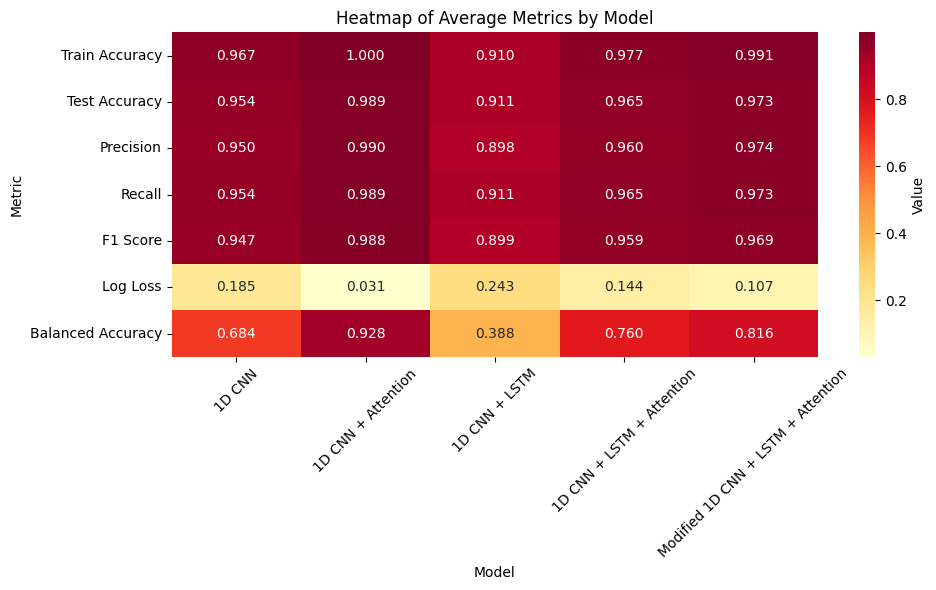

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(metric_df.set_index('Model').T, annot=True, cmap='YlOrRd', fmt='.3f', cbar_kws={'label': 'Value'})
plt.title('Heatmap of Average Metrics by Model')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.ylabel('Metric')
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

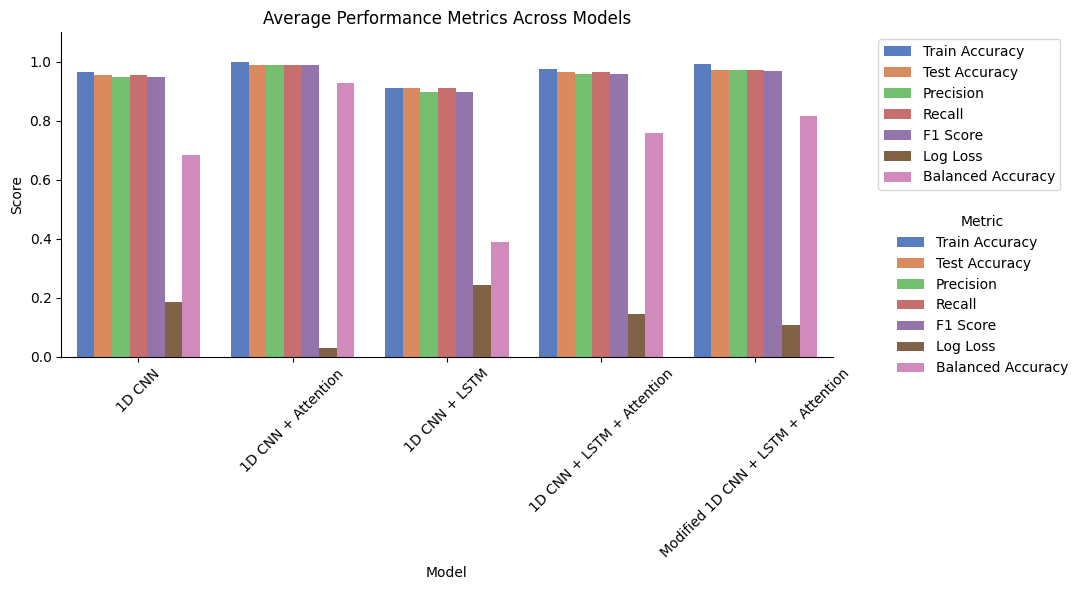

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Melt the DataFrame for easier plotting with seaborn
metric_df_melted = metric_df.melt(id_vars='Model', var_name='Metric', value_name='Value')

# Create a grouped bar plot
plt.figure(figsize=(12, 6))
sns.catplot(x='Model', y='Value', hue='Metric', kind='bar', data=metric_df_melted, height=6, aspect=1.5, palette='muted')
plt.title('Average Performance Metrics Across Models')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 1.1)  # Adjust based on your data range (e.g., log loss might need scaling)
plt.tight_layout()
plt.show()

In [3]:
import pandas as pd

# Define the updated data
data = {
    'Model': [
        '1D CNN',
        '1D CNN + Attention',
        '1D CNN + LSTM',
        '1D CNN + LSTM + Attention',
        'Modified 1D CNN + LSTM + Attention'
    ],
    'Train Accuracy': [
        [0.951, 0.976, 0.983, 0.956, 0.968],
        [1.0, 1.0, 1.0, 0.999, 1.0],
        [0.905, 0.897, 0.923, 0.918, 0.909],
        [0.968, 0.991, 0.983, 0.965, 0.979],
        [0.999, 0.987, 0.998, 0.991, 0.982]
    ],
    'Test Accuracy': [
        [0.939, 0.965, 0.962, 0.948, 0.956],
        [1.0, 0.98, 0.994, 0.985, 0.988],
        [0.895, 0.895, 0.927, 0.922, 0.916],
        [0.953, 0.985, 0.98, 0.936, 0.971],
        [0.974, 0.965, 0.983, 0.971, 0.974]
    ],
    'Precision': [
        [0.937, 0.961, 0.959, 0.937, 0.956],
        [1.0, 0.973, 0.996, 0.991, 0.991],
        [0.88, 0.875, 0.916, 0.916, 0.904],
        [0.93, 0.989, 0.972, 0.938, 0.969],
        [0.973, 0.968, 0.989, 0.971, 0.967]
    ],
    'Recall': [
        [0.939, 0.965, 0.962, 0.948, 0.956],
        [1.0, 0.98, 0.994, 0.985, 0.988],
        [0.895, 0.895, 0.927, 0.922, 0.916],
        [0.953, 0.985, 0.98, 0.936, 0.971],
        [0.974, 0.965, 0.983, 0.971, 0.974]
    ],
    'F1 Score': [
        [0.931, 0.96, 0.956, 0.936, 0.952],
        [1.0, 0.975, 0.994, 0.983, 0.989],
        [0.882, 0.879, 0.91, 0.915, 0.901],
        [0.939, 0.985, 0.975, 0.932, 0.964],
        [0.969, 0.959, 0.98, 0.969, 0.969]
    ],
    'Log Loss': [
        [0.291, 0.171, 0.094, 0.186, 0.185],
        [0.007, 0.06, 0.024, 0.038, 0.025],
        [0.235, 0.272, 0.209, 0.242, 0.256],
        [0.15, 0.111, 0.138, 0.186, 0.137],
        [0.117, 0.121, 0.091, 0.099, 0.109]
    ],
    'Balanced Accuracy': [
        [0.58, 0.76, 0.74, 0.64, 0.7],
        [1.0, 0.86, 0.96, 0.9, 0.92],
        [0.28, 0.28, 0.5, 0.46, 0.42],
        [0.68, 0.9, 0.86, 0.56, 0.8],
        [0.82, 0.76, 0.88, 0.8, 0.82]
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Display DataFrame
print(df)

# Save to CSV (optional)
df.to_csv('CWRU_IR_50_1_all_metrics.csv', index=False)


                                Model                       Train Accuracy  \
0                              1D CNN  [0.951, 0.976, 0.983, 0.956, 0.968]   
1                  1D CNN + Attention          [1.0, 1.0, 1.0, 0.999, 1.0]   
2                       1D CNN + LSTM  [0.905, 0.897, 0.923, 0.918, 0.909]   
3           1D CNN + LSTM + Attention  [0.968, 0.991, 0.983, 0.965, 0.979]   
4  Modified 1D CNN + LSTM + Attention  [0.999, 0.987, 0.998, 0.991, 0.982]   

                         Test Accuracy                            Precision  \
0  [0.939, 0.965, 0.962, 0.948, 0.956]  [0.937, 0.961, 0.959, 0.937, 0.956]   
1     [1.0, 0.98, 0.994, 0.985, 0.988]    [1.0, 0.973, 0.996, 0.991, 0.991]   
2  [0.895, 0.895, 0.927, 0.922, 0.916]   [0.88, 0.875, 0.916, 0.916, 0.904]   
3   [0.953, 0.985, 0.98, 0.936, 0.971]   [0.93, 0.989, 0.972, 0.938, 0.969]   
4  [0.974, 0.965, 0.983, 0.971, 0.974]  [0.973, 0.968, 0.989, 0.971, 0.967]   

                                Recall                  

In [2]:
df

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,Log Loss,Balanced Accuracy
0,1D CNN,"[0.951, 0.976, 0.983, 0.956, 0.968]","[0.939, 0.965, 0.962, 0.948, 0.956]","[0.937, 0.961, 0.959, 0.937, 0.956]","[0.939, 0.965, 0.962, 0.948, 0.956]","[0.931, 0.96, 0.956, 0.936, 0.952]","[0.291, 0.171, 0.094, 0.186, 0.185]","[0.58, 0.76, 0.74, 0.64, 0.7]"
1,1D CNN + Attention,"[1.0, 1.0, 1.0, 0.999, 1.0]","[1.0, 0.98, 0.994, 0.985, 0.988]","[1.0, 0.973, 0.996, 0.991, 0.991]","[1.0, 0.98, 0.994, 0.985, 0.988]","[1.0, 0.975, 0.994, 0.983, 0.989]","[0.007, 0.06, 0.024, 0.038, 0.025]","[1.0, 0.86, 0.96, 0.9, 0.92]"
2,1D CNN + LSTM,"[0.905, 0.897, 0.923, 0.918, 0.909]","[0.895, 0.895, 0.927, 0.922, 0.916]","[0.88, 0.875, 0.916, 0.916, 0.904]","[0.895, 0.895, 0.927, 0.922, 0.916]","[0.882, 0.879, 0.91, 0.915, 0.901]","[0.235, 0.272, 0.209, 0.242, 0.256]","[0.28, 0.28, 0.5, 0.46, 0.42]"
3,1D CNN + LSTM + Attention,"[0.968, 0.991, 0.983, 0.965, 0.979]","[0.953, 0.985, 0.98, 0.936, 0.971]","[0.93, 0.989, 0.972, 0.938, 0.969]","[0.953, 0.985, 0.98, 0.936, 0.971]","[0.939, 0.985, 0.975, 0.932, 0.964]","[0.15, 0.111, 0.138, 0.186, 0.137]","[0.68, 0.9, 0.86, 0.56, 0.8]"
4,Modified 1D CNN + LSTM + Attention,"[0.999, 0.987, 0.998, 0.991, 0.982]","[0.974, 0.965, 0.983, 0.971, 0.974]","[0.973, 0.968, 0.989, 0.971, 0.967]","[0.974, 0.965, 0.983, 0.971, 0.974]","[0.969, 0.959, 0.98, 0.969, 0.969]","[0.117, 0.121, 0.091, 0.099, 0.109]","[0.82, 0.76, 0.88, 0.8, 0.82]"


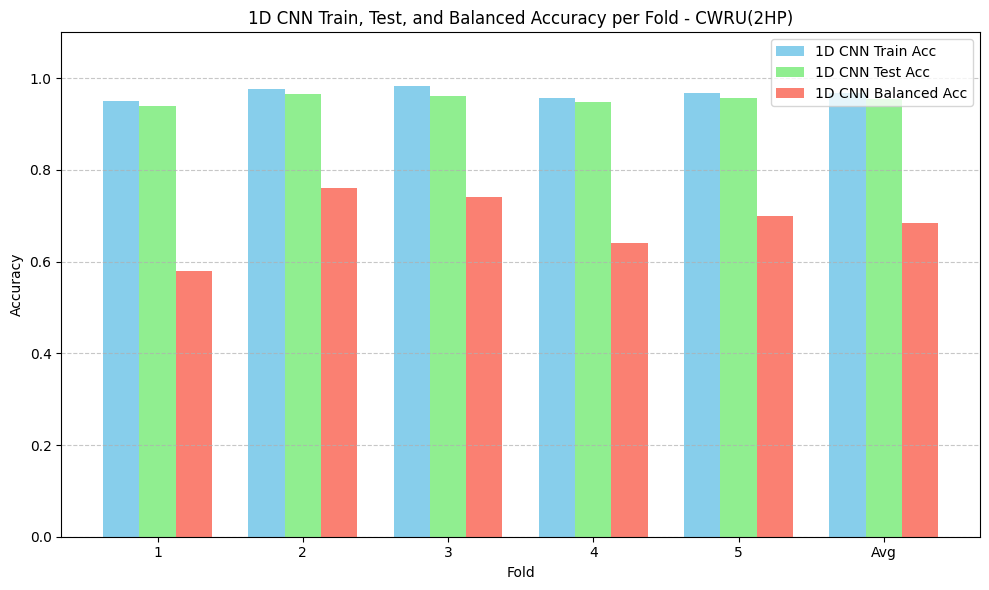

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Define fold-wise metrics
folds = ['1', '2', '3', '4', '5', 'Avg']

# 1D CNN
cnn_train = [0.951, 0.976, 0.983, 0.956, 0.968]
cnn_test = [0.939, 0.965, 0.962, 0.948, 0.956]
cnn_bal = [0.58, 0.76, 0.74, 0.64, 0.7]
cnn_train.append(np.mean(cnn_train))
cnn_test.append(np.mean(cnn_test))
cnn_bal.append(np.mean(cnn_bal))

# 1D CNN + LSTM
lstm_train = [0.905, 0.897, 0.923, 0.918, 0.909]
lstm_test = [0.895, 0.895, 0.927, 0.922, 0.916]
lstm_bal = [0.28, 0.28, 0.5, 0.46, 0.42]
lstm_train.append(np.mean(lstm_train))
lstm_test.append(np.mean(lstm_test))
lstm_bal.append(np.mean(lstm_bal))

# Plot
bar_width = 0.25
x = np.arange(len(folds))

plt.figure(figsize=(10, 6))

# 1D CNN
plt.bar(x - bar_width, cnn_train, width=bar_width, label='1D CNN Train Acc', color='skyblue')
plt.bar(x, cnn_test, width=bar_width, label='1D CNN Test Acc', color='lightgreen')
plt.bar(x + bar_width, cnn_bal, width=bar_width, label='1D CNN Balanced Acc', color='salmon')

# 1D CNN + LSTM (optional separate plot for clarity)
# Uncomment this to plot them together:
# plt.bar(x - bar_width, lstm_train, width=bar_width, label='CNN+LSTM Train Acc', color='blue')
# plt.bar(x, lstm_test, width=bar_width, label='CNN+LSTM Test Acc', color='green')
# plt.bar(x + bar_width, lstm_bal, width=bar_width, label='CNN+LSTM Balanced Acc', color='red')

# Labels and Title
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('1D CNN Train, Test, and Balanced Accuracy per Fold - CWRU(2HP)')
plt.xticks(ticks=x, labels=folds)
plt.ylim(0, 1.1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


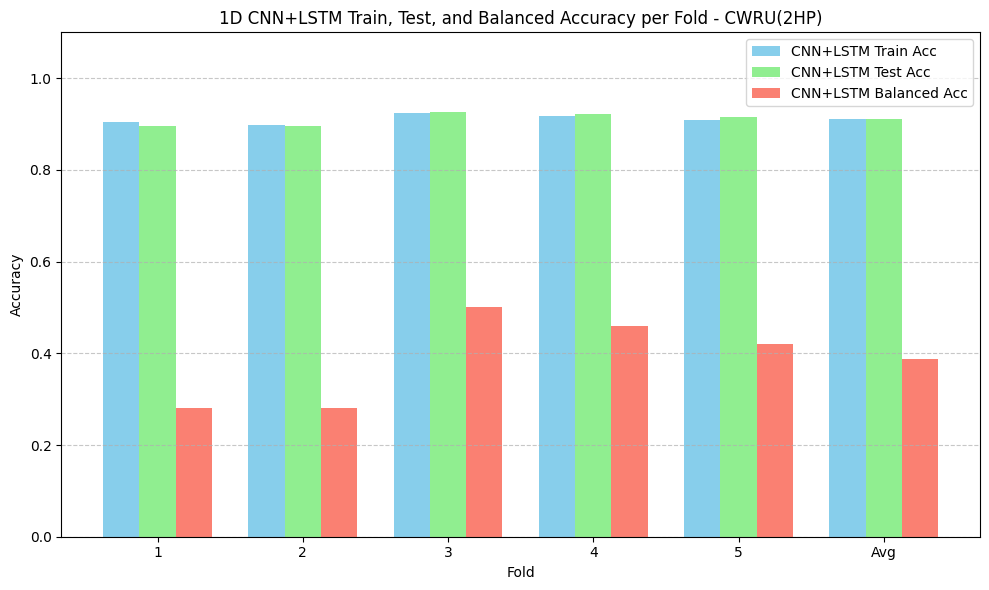

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Define fold-wise metrics
folds = ['1', '2', '3', '4', '5', 'Avg']

# 1D CNN
cnn_train = [0.951, 0.976, 0.983, 0.956, 0.968]
cnn_test = [0.939, 0.965, 0.962, 0.948, 0.956]
cnn_bal = [0.58, 0.76, 0.74, 0.64, 0.7]
cnn_train.append(np.mean(cnn_train))
cnn_test.append(np.mean(cnn_test))
cnn_bal.append(np.mean(cnn_bal))

# 1D CNN + LSTM
lstm_train = [0.905, 0.897, 0.923, 0.918, 0.909]
lstm_test = [0.895, 0.895, 0.927, 0.922, 0.916]
lstm_bal = [0.28, 0.28, 0.5, 0.46, 0.42]
lstm_train.append(np.mean(lstm_train))
lstm_test.append(np.mean(lstm_test))
lstm_bal.append(np.mean(lstm_bal))

# Plot
bar_width = 0.25
x = np.arange(len(folds))

plt.figure(figsize=(10, 6))

# 1D CNN
# plt.bar(x - bar_width, cnn_train, width=bar_width, label='1D CNN Train Acc', color='skyblue')
# plt.bar(x, cnn_test, width=bar_width, label='1D CNN Test Acc', color='lightgreen')
# plt.bar(x + bar_width, cnn_bal, width=bar_width, label='1D CNN Balanced Acc', color='salmon')

# 1D CNN + LSTM (optional separate plot for clarity)
plt.bar(x - bar_width, lstm_train, width=bar_width, label='CNN+LSTM Train Acc', color='skyblue')
plt.bar(x, lstm_test, width=bar_width, label='CNN+LSTM Test Acc', color='lightgreen')
plt.bar(x + bar_width, lstm_bal, width=bar_width, label='CNN+LSTM Balanced Acc', color='salmon')

# Labels and Title
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('1D CNN+LSTM Train, Test, and Balanced Accuracy per Fold - CWRU(2HP)')
plt.xticks(ticks=x, labels=folds)
plt.ylim(0, 1.1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


### old code

In [ ]:
# model_1 = load_model(os.path.join(foldername_cnn, "best_model_1.keras"))
# model_2 = load_model(os.path.join(foldername_cnn, "best_model_2.keras"))
# model_3 = load_model(os.path.join(foldername_cnn, "best_model_3.keras"))
# model_4 = load_model(os.path.join(foldername_cnn, "best_model_4.keras"))
# model_5 = load_model(os.path.join(foldername_cnn, "best_model_5.keras"))
# # Initialize lists to store accuracies and fold labels
# from datetime import datetime
# accuracies = []
# balance_accuracies = []
# fold_labels = [f"Fold {i+1}" for i in range(5)]
# models = [model_1, model_2, model_3, model_4, model_5]

# # Predict and calculate accuracy for each model
# for model in models:
#     y_pred_probs = model.predict(X_1D_test, verbose=0)
#     y_pred = np.argmax(y_pred_probs, axis=1)
#     y_true = np.argmax(y_test, axis=1)
#     acc = accuracy_score(y_true, y_pred)
#     balance_acc = balanced_accuracy_score(y_true, y_pred)
#     accuracies.append(acc)
#     balance_accuracies.append(balance_acc)

# # Plot bar chart
# plt.figure(figsize=(8, 6))
# plt.bar(fold_labels, accuracies, color='salmon')
# plt.xlabel('Fold')
# plt.ylabel('Test Accuracy')
# plt.title('Test Accuracy for 1D_CNN (2HP) Across Folds')
# plt.ylim(0, 1)
# plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# # Plot balanced accuracy
# plt.figure(figsize=(8, 6))
# plt.bar(fold_labels, balance_accuracies, color='lightblue')
# plt.xlabel('Fold')
# plt.ylabel('Balanced Test Accuracy')
# plt.title('Balanced Test Accuracy for 1D_CNN (2HP) Across Folds')
# plt.ylim(0, 1)
# plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# # # Add accuracy values on top of bars
# # for i, acc in enumerate(accuracies):
# #     plt.text(i, acc + 0.01, f'{acc:.3f}', ha='center', va='top')

# # Save the plot
# plots_dir = os.path.join(foldername_cnn, "Plots", "1D_CNN", "2HP")
# os.makedirs(plots_dir, exist_ok=True)
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# filepath = os.path.join(plots_dir, f"test_accuracy_bar_chart_{timestamp}.png")
# # plt.savefig(filepath, dpi=300, bbox_inches='tight')
# # plt.close()
# plt.show()

In [40]:
# model_6 = load_model(os.path.join(foldername_cnn_lstm, "1D_CNN_LSTM_best_model_1.keras"))
# model_7 = load_model(os.path.join(foldername_cnn_lstm, "1D_CNN_LSTM_best_model_2.keras"))
# model_8 = load_model(os.path.join(foldername_cnn_lstm, "1D_CNN_LSTM_best_model_3.keras"))
# model_9 = load_model(os.path.join(foldername_cnn_lstm, "1D_CNN_LSTM_best_model_4.keras"))
# model_10 = load_model(os.path.join(foldername_cnn_lstm, "1D_CNN_LSTM_best_model_5.keras"))
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import accuracy_score
# from datetime import datetime
# import os

# # Initialize lists to store accuracies and fold labels
# accuracies = []
# balance_accuracies = []
# fold_labels = [f"Fold {i+1}" for i in range(5)]
# models = [model_6, model_7, model_8, model_9, model_10]

# # Predict and calculate accuracy for each model
# for model in models:
#     y_pred_probs = model.predict(X_1D_test, verbose=0)
#     y_pred = np.argmax(y_pred_probs, axis=1)
#     y_true = np.argmax(y_test, axis=1)
#     acc = accuracy_score(y_true, y_pred)
#     balance_acc = balanced_accuracy_score(y_true, y_pred)
#     accuracies.append(acc)
#     balance_accuracies.append(balance_acc)

# # Plot bar chart
# plt.figure(figsize=(8, 6))
# plt.bar(fold_labels, accuracies, color='salmon')
# plt.xlabel('Fold')
# plt.ylabel('Test Accuracy')
# plt.title('Test Accuracy for 1D_CNN_LSTM (2HP) Across Folds')
# plt.ylim(0, 1)
# plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# # Plot balanced accuracy
# plt.figure(figsize=(8, 6))
# plt.bar(fold_labels, balance_accuracies, color='lightblue')
# plt.xlabel('Fold')
# plt.ylabel('Balanced Test Accuracy')
# plt.title('Balanced Test Accuracy for 1D_CNN_LSTM (2HP) Across Folds')
# plt.ylim(0, 1)
# plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# # # Add accuracy values on top of bars
# # for i, acc in enumerate(accuracies):
# #     plt.text(i, acc + 0.01, f'{acc:.3f}', ha='center', va='top')

# # Save the plot
# plots_dir = os.path.join(foldername_cnn, "Plots", "1D_CNN", "2HP")
# os.makedirs(plots_dir, exist_ok=True)
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# filepath = os.path.join(plots_dir, f"test_accuracy_bar_chart_{timestamp}.png")
# # plt.savefig(filepath, dpi=300, bbox_inches='tight')
# # plt.close()
# plt.show()

In [41]:
# model_11 = load_model(os.path.join(foldername_cnn_attn, "1D_CNN_Attention_best_model_1.keras"))
# model_12 = load_model(os.path.join(foldername_cnn_attn, "1D_CNN_Attention_best_model_2.keras"))
# model_13 = load_model(os.path.join(foldername_cnn_attn, "1D_CNN_Attention_best_model_3.keras"))
# model_14 = load_model(os.path.join(foldername_cnn_attn, "1D_CNN_Attention_best_model_4.keras"))
# model_15 = load_model(os.path.join(foldername_cnn_attn, "1D_CNN_Attention_best_model_5.keras"))
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import accuracy_score
# from datetime import datetime
# import os

# # Initialize lists to store accuracies and fold labels
# accuracies = []
# balance_accuracies = []
# fold_labels = [f"Fold {i+1}" for i in range(5)]
# models = [model_11, model_12, model_13, model_14, model_15]

# # Predict and calculate accuracy for each model
# for model in models:
#     y_pred_probs = model.predict(X_1D_test, verbose=0)
#     y_pred = np.argmax(y_pred_probs, axis=1)
#     y_true = np.argmax(y_test, axis=1)
#     acc = accuracy_score(y_true, y_pred)
#     balance_acc = balanced_accuracy_score(y_true, y_pred)
#     accuracies.append(acc)
#     balance_accuracies.append(balance_acc)

# # Plot bar chart
# plt.figure(figsize=(8, 6))
# plt.bar(fold_labels, accuracies, color='salmon')
# plt.xlabel('Fold')
# plt.ylabel('Test Accuracy')
# plt.title('Test Accuracy for 1D_CNN_Attention (2HP) Across Folds')
# plt.ylim(0, 1)
# plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# # Plot balanced accuracy
# plt.figure(figsize=(8, 6))
# plt.bar(fold_labels, balance_accuracies, color='lightblue')
# plt.xlabel('Fold')
# plt.ylabel('Balanced Test Accuracy')
# plt.title('Balanced Test Accuracy for 1D_CNN_Attention (2HP) Across Folds')
# plt.ylim(0, 1)
# plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# # # Add accuracy values on top of bars
# # for i, acc in enumerate(accuracies):
# #     plt.text(i, acc + 0.01, f'{acc:.3f}', ha='center', va='top')

# # Save the plot
# plots_dir = os.path.join(foldername_cnn, "Plots", "1D_CNN", "2HP")
# os.makedirs(plots_dir, exist_ok=True)
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# filepath = os.path.join(plots_dir, f"test_accuracy_bar_chart_{timestamp}.png")
# # plt.savefig(filepath, dpi=300, bbox_inches='tight')
# # plt.close()
# plt.show()

In [42]:
# model_16 = load_model(os.path.join(foldername_cnn_lstm_attn, "1D_CNN_LSTM_Attention_best_model_1.keras"))
# model_17 = load_model(os.path.join(foldername_cnn_lstm_attn, "1D_CNN_LSTM_Attention_best_model_2.keras"))
# model_18 = load_model(os.path.join(foldername_cnn_lstm_attn, "1D_CNN_LSTM_Attention_best_model_3.keras"))
# model_19 = load_model(os.path.join(foldername_cnn_lstm_attn, "1D_CNN_LSTM_Attention_best_model_4.keras"))
# model_20 = load_model(os.path.join(foldername_cnn_lstm_attn, "1D_CNN_LSTM_Attention_best_model_5.keras"))
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import accuracy_score
# from datetime import datetime
# import os

# # Initialize lists to store accuracies and fold labels
# accuracies = []
# balance_accuracies = []
# fold_labels = [f"Fold {i+1}" for i in range(5)]
# models = [model_16, model_17, model_18, model_19, model_20]

# # Predict and calculate accuracy for each model
# for model in models:
#     y_pred_probs = model.predict(X_1D_test, verbose=0)
#     y_pred = np.argmax(y_pred_probs, axis=1)
#     y_true = np.argmax(y_test, axis=1)
#     acc = accuracy_score(y_true, y_pred)
#     balance_acc = balanced_accuracy_score(y_true, y_pred)
#     accuracies.append(acc)
#     balance_accuracies.append(balance_acc)

# # Plot bar chart
# plt.figure(figsize=(8, 6))
# plt.bar(fold_labels, accuracies, color='salmon')
# plt.xlabel('Fold')
# plt.ylabel('Test Accuracy')
# plt.title('Test Accuracy for 1D_CNN_LSTM_Attention (2HP) Across Folds')
# plt.ylim(0, 1)
# plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# # Plot balanced accuracy
# plt.figure(figsize=(8, 6))
# plt.bar(fold_labels, balance_accuracies, color='lightblue')
# plt.xlabel('Fold')
# plt.ylabel('Balanced Test Accuracy')
# plt.title('Balanced Test Accuracy for 1D_CNN_LSTM_Attention (2HP) Across Folds')
# plt.ylim(0, 1)
# plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# # # Add accuracy values on top of bars
# # for i, acc in enumerate(accuracies):
# #     plt.text(i, acc + 0.01, f'{acc:.3f}', ha='center', va='top')

# # Save the plot
# plots_dir = os.path.join(foldername_cnn, "Plots", "1D_CNN", "2HP")
# os.makedirs(plots_dir, exist_ok=True)
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# filepath = os.path.join(plots_dir, f"test_accuracy_bar_chart_{timestamp}.png")
# # plt.savefig(filepath, dpi=300, bbox_inches='tight')
# # plt.close()
# plt.show()

In [43]:
# model_21 = load_model(os.path.join(foldername_cnn_lstm_attn, "modified_1D_CNN_LSTM_Attention_best_model_1.keras"))
# model_22 = load_model(os.path.join(foldername_cnn_lstm_attn, "modified_1D_CNN_LSTM_Attention_best_model_2.keras"))
# model_23 = load_model(os.path.join(foldername_cnn_lstm_attn, "modified_1D_CNN_LSTM_Attention_best_model_3.keras"))
# model_24 = load_model(os.path.join(foldername_cnn_lstm_attn, "modified_1D_CNN_LSTM_Attention_best_model_4.keras"))
# model_25 = load_model(os.path.join(foldername_cnn_lstm_attn, "modified_1D_CNN_LSTM_Attention_best_model_5.keras"))
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import accuracy_score
# from datetime import datetime
# import os

# # Initialize lists to store accuracies and fold labels
# accuracies = []
# balance_accuracies = []
# fold_labels = [f"Fold {i+1}" for i in range(5)]
# models = [model_16, model_17, model_18, model_19, model_20]

# # Predict and calculate accuracy for each model
# for model in models:
#     y_pred_probs = model.predict(X_1D_test, verbose=0)
#     y_pred = np.argmax(y_pred_probs, axis=1)
#     y_true = np.argmax(y_test, axis=1)
#     acc = accuracy_score(y_true, y_pred)
#     balance_acc = balanced_accuracy_score(y_true, y_pred)
#     accuracies.append(acc)
#     balance_accuracies.append(balance_acc)

# # Plot bar chart
# plt.figure(figsize=(8, 6))
# plt.bar(fold_labels, accuracies, color='salmon')
# plt.xlabel('Fold')
# plt.ylabel('Test Accuracy')
# plt.title('Test Accuracy for modified 1D_CNN_LSTM_Attention (2HP) Across Folds')
# plt.ylim(0, 1)
# plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# # Plot balanced accuracy
# plt.figure(figsize=(8, 6))
# plt.bar(fold_labels, balance_accuracies, color='lightblue')
# plt.xlabel('Fold')
# plt.ylabel('Balanced Test Accuracy')
# plt.title('Balanced Test Accuracy for modified 1D_CNN_LSTM_Attention (2HP) Across Folds')
# plt.ylim(0, 1)
# plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# # # Add accuracy values on top of bars
# # for i, acc in enumerate(accuracies):
# #     plt.text(i, acc + 0.01, f'{acc:.3f}', ha='center', va='top')

# # Save the plot
# plots_dir = os.path.join(foldername_cnn, "Plots", "1D_CNN", "2HP")
# os.makedirs(plots_dir, exist_ok=True)
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# filepath = os.path.join(plots_dir, f"test_accuracy_bar_chart_{timestamp}.png")
# # plt.savefig(filepath, dpi=300, bbox_inches='tight')
# # plt.close()
# plt.show()

In [ ]:
# import os
# import numpy as np
# import pandas as pd
# import seaborn as sns 
# from sklearn.model_selection import train_test_split, StratifiedKFold
# import tensorflow as tf
# from keras import layers, models, Input
# from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# from keras.models import load_model
# from keras.regularizers import l2

# import scipy.io 
# import matplotlib.pyplot as plt

# from sklearn.metrics import (
#     accuracy_score,
#     precision_score,
#     recall_score,
#     f1_score,
#     log_loss,
#     classification_report,
#     confusion_matrix,
#     roc_auc_score,
#     balanced_accuracy_score
# )
# from keras.layers import (
#     MultiHeadAttention, LayerNormalization, Dropout, Dense, GlobalAveragePooling1D, Conv1D, MaxPooling1D, BatchNormalization,
#     Reshape, multiply, LSTM, Bidirectional, Concatenate, Add, Activation
# )

# # Data loading
# folder_path1 = os.path.join(os.getcwd(), 'CWRU_data', '2HP')
# folder_path2 = os.path.join(os.getcwd(), 'CWRU_data', '3HP')

# def load_cwru_data(folder_path = folder_path1):
#     data_dict = {
#         'Condition': [],
#         'Fault Size (mm)': [],
#         'Fault Label': [],
#         'Signal': []
#     }
#     file_mappings_2HP = [
#         ('99', 'Normal', 0, 0),
#         ('124', 'RE (Rolling element)', 0.18, 1),
#         ('111', 'IR (Inner ring)', 0.18, 2),
#         ('137', 'OR (Outer ring)', 0.18, 3),
#         ('191', 'RE (Rolling element)', 0.36, 4),
#         ('176', 'IR (Inner ring)', 0.36, 5),
#         ('203', 'OR (Outer ring)', 0.36, 6),
#         ('228', 'RE (Rolling element)', 0.54, 7),
#         ('215', 'IR (Inner ring)', 0.54, 8),
#         ('240', 'OR (Outer ring)', 0.54, 9)
#     ]
#     for file_id, condition, fault_size, fault_label in file_mappings_2HP:
#         file_path = os.path.join(folder_path, f'{file_id}.mat')
#         if file_id == '99':
#             signal = scipy.io.loadmat(file_path)[f'X0{file_id}_DE_time'].flatten()
#         else:
#             signal = scipy.io.loadmat(file_path)[f'X{file_id}_DE_time'].flatten()
#         data_dict['Condition'].append(condition)
#         data_dict['Fault Size (mm)'].append(fault_size)
#         data_dict['Fault Label'].append(fault_label)
#         data_dict['Signal'].append(signal)
#     return pd.DataFrame(data_dict)

# df = load_cwru_data(folder_path=folder_path1)

# def preprocess_data_for_imbalance(df, start_point_dict, num_points_dict):
#     processed_data = {
#         'Condition': [],
#         'Fault Size (mm)': [],
#         'Fault Label': [],
#         'Signal': []
#     }
#     for fault_label in df['Fault Label'].unique():
#         subset = df[df['Fault Label'] == fault_label]
#         if subset.empty:
#             continue
#         signal = subset.iloc[0]['Signal']
#         condition = subset.iloc[0]['Condition']
#         fault_size = subset.iloc[0]['Fault Size (mm)']
#         start_point = start_point_dict.get(fault_label, 0)
#         num_points = num_points_dict.get(fault_label, len(signal))
#         if start_point >= len(signal):
#             print(f"Start point {start_point} is out of range for signal with length {len(signal)}. Skipping Fault Label {fault_label}.")
#             continue
#         end_point = min(start_point + num_points, len(signal))
#         signal_section = signal[start_point:end_point]
#         processed_data['Condition'].append(condition)
#         processed_data['Fault Size (mm)'].append(fault_size)
#         processed_data['Fault Label'].append(fault_label)
#         processed_data['Signal'].append(signal_section)
#     return pd.DataFrame(processed_data)

# start_point_dict_train = {label: 0 for label in range(10)}
# num_points_dict_train = {0: 480000, **{label: 9600 for label in range(1, 10)}}
# df_imbalance_train = preprocess_data_for_imbalance(df, start_point_dict_train, num_points_dict_train)

# def sampling(data, interval_length, samples_per_block, ignore_points=0):
#     adjusted_length = len(data) - 2 * ignore_points
#     num_blocks = (
#         round(adjusted_length / interval_length) - round(samples_per_block / interval_length) - 1
#     )
#     split_data = np.zeros([num_blocks, samples_per_block])
#     for i in range(num_blocks):
#         start_idx = ignore_points + i * interval_length
#         split_data[i, :] = data[start_idx:(start_idx + samples_per_block)].T
#     return split_data

# def data_preparation(data, interval_length, samples_per_block):
#     for count, signal in enumerate(data):
#         split_data = sampling(signal, interval_length, samples_per_block)
#         y = np.zeros([len(split_data), 10])
#         y[:, count] = 1
#         y_class = np.zeros([len(split_data), 1])
#         y_class[:, 0] = count
#         if count == 0:
#             X = split_data
#             y_positional = y
#             y_label = y_class
#         else:
#             X = np.append(X, split_data, axis=0)
#             y_positional = np.append(y_positional, y, axis=0)
#             y_label = np.append(y_label, y_class, axis=0)
#     return X, y_positional, y_label

# def prepare_datasets(df_imbalance, interval_length, samples_per_block):
#     signals = df_imbalance['Signal'].tolist()
#     X, y_positional, y_class = data_preparation(signals, interval_length, samples_per_block)
#     return X, y_positional, y_class

# interval_length = 320
# samples_per_block = 1600
# X, y_positional, y_class = prepare_datasets(df_imbalance_train, interval_length, samples_per_block)

# def time_series_stratified_split(X, y, train_ratio = 0.8):
#     num_classes = y.shape[1]
#     X_train, y_train, X_test, y_test = [], [], [], []
#     for cls in range(num_classes):
#         cls_indices = np.where(np.argmax(y, axis=1) == cls)[0]
#         n_train = int(train_ratio * len(cls_indices))
#         train_idx, test_idx = cls_indices[:n_train], cls_indices[n_train:]
#         X_train.append(X[train_idx])
#         y_train.append(y[train_idx])
#         X_test.append(X[test_idx])
#         y_test.append(y[test_idx])
#     return (
#         np.concatenate(X_train),
#         np.concatenate(y_train),
#         np.concatenate(X_test),
#         np.concatenate(y_test)
#     )

# foldername_cnn = os.path.join(os.getcwd(), "Imbalanced_Final_Results", "IR_50_1_Ratio", "1D_CNN")
# foldername_cnn_attn = os.path.join(os.getcwd(), "Imbalanced_Final_Results", "IR_50_1_Ratio", "1D_CNN_Attention")
# foldername_cnn_lstm = os.path.join(os.getcwd(), "Imbalanced_Final_Results", "IR_50_1_Ratio", "1D_CNN_LSTM")
# foldername_cnn_lstm_attn = os.path.join(os.getcwd(), "Imbalanced_Final_Results", "IR_50_1_Ratio", "1D_CNN_LSTM_Attention")
# os.makedirs(foldername_cnn, exist_ok=True)
# os.makedirs(foldername_cnn_attn, exist_ok=True)
# os.makedirs(foldername_cnn_lstm, exist_ok=True)
# os.makedirs(foldername_cnn_lstm_attn, exist_ok=True)

# X_train, y_train, X_test, y_test = time_series_stratified_split(X=X, y=y_positional, train_ratio=0.8)
# X_1D_train = X_train.reshape([-1, samples_per_block, 1])
# X_1D_test = X_test.reshape([-1, samples_per_block, 1])
# input_shape = (samples_per_block, 1)
# y_train_classes = np.argmax(y_train, axis=1)
# k_splits = 5
# kfold = StratifiedKFold(n_splits=k_splits, shuffle=False)

# # 1D CNN Model
# class CNN_1D():
#     def __init__(self):
#         self.model = self.CreateModel()
#         self.model.summary()
#     def CreateModel(self):
#         model = models.Sequential([
#             layers.Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=input_shape),
#             layers.BatchNormalization(),
#             layers.MaxPool1D(pool_size=2),
#             layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'),
#             layers.BatchNormalization(),
#             layers.MaxPool1D(pool_size=2),
#             layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'),
#             layers.BatchNormalization(),
#             layers.MaxPool1D(pool_size=2),
#             layers.GlobalAveragePooling1D(),
#             layers.Dense(64, activation='relu'),
#             layers.Dropout(0.3),
#             layers.Dense(10, activation='softmax')
#         ])
#         model.compile(optimizer='adam',
#                       loss=tf.keras.losses.CategoricalCrossentropy(),
#                       metrics=['accuracy'])
#         model.summary()
#         return model

# # 1D CNN + Attention Model
# class CNN_1D_Attn():
#     def __init__(self, input_shape):
#         self.model = self.CreateModel(input_shape)
#         self.model.summary()
#     def CreateModel(self, input_shape):
#         inputs = Input(shape=input_shape)
#         x = Conv1D(16, 3, strides=1, padding='same', activation='relu')(inputs)
#         x = BatchNormalization()(x)
#         x = MaxPooling1D(pool_size=2)(x)
#         x = Conv1D(32, 3, strides=1, padding='same', activation='relu')(x)
#         x = BatchNormalization()(x)
#         x = MaxPooling1D(pool_size=2)(x)
#         x = Conv1D(64, 3, strides=1, padding='same', activation='relu')(x)
#         x = BatchNormalization()(x)
#         x = MaxPooling1D(pool_size=2)(x)
#         x_norm = LayerNormalization()(x)
#         attn_output = MultiHeadAttention(num_heads=4, key_dim=16)(x_norm, x_norm)
#         x = layers.Add()([x, attn_output])
#         x = LayerNormalization()(x)
#         x = GlobalAveragePooling1D()(x)
#         x = Dense(64, activation='relu')(x)
#         x = Dropout(0.3)(x)
#         output = Dense(10, activation='softmax')(x)
#         model = models.Model(inputs, output)
#         model.compile(
#             optimizer='adam',
#             loss=tf.keras.losses.CategoricalCrossentropy(),
#             metrics=['accuracy']
#         )
#         model.summary()
#         return model

# # 1D CNN + LSTM Model
# class CNN_LSTM_1D():
#     def __init__(self):
#         self.model = self.build_model()
#         self.model.summary()
#     def build_model(self):
#         input_seq = Input(shape=(1600,))
#         X = Reshape((1600, 1))(input_seq)
#         ec1_layer1 = Conv1D(50, 20, strides=2, activation='relu')(X)
#         ec1_layer2 = Conv1D(30, 10, strides=2, activation='relu')(ec1_layer1)
#         ec1_outputs = MaxPooling1D(pool_size=2)(ec1_layer2)
#         ec2_layer1 = Conv1D(50, 8, strides=2, activation='relu')(X)
#         ec2_layer2 = Conv1D(40, 6, strides=2, activation='relu')(ec2_layer1)
#         ec2_layer3 = MaxPooling1D(pool_size=2)(ec2_layer2)
#         ec2_layer4 = Conv1D(30, 4, strides=1, activation='relu')(ec2_layer3)
#         ec2_outputs = ec2_layer4
#         encoder = multiply([ec1_outputs, ec2_outputs])
#         x = LSTM(60, return_sequences=True)(encoder)
#         x = LSTM(60)(x)
#         x = Dropout(0.5)(x)
#         output = Dense(10, activation='softmax')(x)
#         model = models.Model(input_seq, output)
#         model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#         model.summary()
#         return model

# # 1D CNN + LSTM + Attention Model
# class CNN_1D_LSTM_Attention():
#     def __init__(self):
#         self.model = self.build_model()
#         self.model.summary()
#     def build_model(self):
#         input_seq = Input(shape=(1600,))
#         X = Reshape((1600, 1))(input_seq)
#         branch1 = Conv1D(32, 10, strides=2, padding='same')(X)
#         branch1 = BatchNormalization()(branch1)
#         branch1 = Activation('relu')(branch1)
#         branch1 = Conv1D(16, 5, strides=2, padding='same')(branch1)
#         branch1 = BatchNormalization()(branch1)
#         branch1 = Activation('relu')(branch1)
#         branch1 = MaxPooling1D(pool_size=2)(branch1)
#         shortcut1 = Conv1D(16, 1, strides=4, padding='same')(X)
#         shortcut1 = MaxPooling1D(pool_size=2)(shortcut1)
#         branch1 = Add()([branch1, shortcut1])
#         branch2 = Conv1D(32, 6, strides=2, padding='same')(X)
#         branch2 = BatchNormalization()(branch2)
#         branch2 = Activation('relu')(branch2)
#         branch2 = Conv1D(16, 3, strides=2, padding='same')(branch2)
#         branch2 = BatchNormalization()(branch2)
#         branch2 = Activation('relu')(branch2)
#         branch2 = MaxPooling1D(pool_size=2)(branch2)
#         combined = Concatenate(axis=-1)([branch1, branch2])
#         combined = LayerNormalization()(combined)
#         attn_out = MultiHeadAttention(num_heads=4, key_dim=8)(combined, combined)
#         attn_out = LayerNormalization()(attn_out)
#         x = Bidirectional(LSTM(32, return_sequences=True))(attn_out)
#         x = Bidirectional(LSTM(32))(x)
#         x = Dense(64, activation='relu')(x)
#         x = Dropout(0.3)(x)
#         output = Dense(10, activation='softmax', kernel_regularizer=l2(0.01))(x)
#         model = models.Model(input_seq, output)
#         model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
#                       loss='categorical_crossentropy',
#                       metrics=['accuracy'])
#         model.summary()
#         return model

# # Modified Model
# class CNN_1D_LSTM_Attn_Modified():
#     def __init__(self):
#         self.model = self.build_model()
#         self.model.summary()
#     def build_model(self):
#         input_seq = Input(shape=(1600,))
#         X = Reshape((1600, 1))(input_seq)
#         branch1 = Conv1D(64, 10, strides=2, padding='same')(X)
#         branch1 = BatchNormalization()(branch1)
#         branch1 = Activation('relu')(branch1)
#         branch1 = Conv1D(64, 5, strides=2, padding='same')(branch1)
#         branch1 = BatchNormalization()(branch1)
#         branch1 = Activation('relu')(branch1)
#         branch1 = MaxPooling1D(pool_size=2)(branch1)
#         shortcut1 = Conv1D(64, 1, strides=4, padding='same')(X)
#         shortcut1 = MaxPooling1D(pool_size=2)(shortcut1)
#         branch1 = Add()([branch1, shortcut1])
#         branch2 = Conv1D(64, 6, strides=2, padding='same')(X)
#         branch2 = BatchNormalization()(branch2)
#         branch2 = Activation('relu')(branch2)
#         branch2 = Conv1D(32, 3, strides=2, padding='same')(branch2)
#         branch2 = BatchNormalization()(branch2)
#         branch2 = Activation('relu')(branch2)
#         branch2 = MaxPooling1D(pool_size=2)(branch2)
#         combined = Concatenate(axis=-1)([branch1, branch2])
#         combined = LayerNormalization()(combined)
#         attn_out = MultiHeadAttention(num_heads=4, key_dim=8)(combined, combined)
#         attn_out = LayerNormalization()(attn_out)
#         x = Bidirectional(LSTM(32, return_sequences=True))(attn_out)
#         x = Bidirectional(LSTM(32))(x)
#         x = Dense(64, activation='relu')(x)
#         x = Dropout(0.3)(x)
#         output = Dense(10, activation='softmax', kernel_regularizer=l2(0.01))(x)
#         model = models.Model(input_seq, output)
#         model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
#                       loss='categorical_crossentropy',
#                       metrics=['accuracy'])
#         model.summary()
#         return model

# # Example: Train and evaluate 1D CNN model (repeat for other models as needed)
# accuracy_1D, precision_1D, recall_1D, f1_1D, log_loss_1D, balanced_accuracy_1D = [], [], [], [], [], []
# accuracy_1D_test, precision_1D_test, recall_1D_test, f1_1D_test, log_loss_1D_test, balanced_accuracy_1D_test = [], [], [], [], [], []

# for fold, (train_idx, val_idx) in enumerate(kfold.split(X_1D_train, y_train_classes)):
#     print(f"\nFold {fold + 1}")
#     checkpoint_filepath = os.path.join(foldername_cnn, f"best_model_{fold + 1}.keras")
#     checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy',
#                                  save_best_only=True, mode='max', verbose=1)
#     model = CNN_1D()
#     model.model.fit(
#         X_1D_train[train_idx], y_train[train_idx],
#         validation_data=(X_1D_train[val_idx], y_train[val_idx]),
#         epochs=20,
#         verbose=1,
#         callbacks=[checkpoint]
#     )
#     best_model = load_model(checkpoint_filepath)
#     y_pred_train_probs = best_model.predict(X_1D_train[train_idx])
#     y_pred_train = np.argmax(y_pred_train_probs, axis=1)
#     y_true_train = np.argmax(y_train[train_idx], axis=1)
#     accuracy_1D.append(round(accuracy_score(y_true_train, y_pred_train), 3))
#     precision_1D.append(round(precision_score(y_true_train, y_pred_train, average='weighted'), 3))
#     recall_1D.append(round(recall_score(y_true_train, y_pred_train, average='weighted'), 3))
#     f1_1D.append(round(f1_score(y_true_train, y_pred_train, average='weighted'), 3))
#     log_loss_1D.append(round(log_loss(y_true_train, y_pred_train_probs), 3))
#     balanced_accuracy_1D.append(round(balanced_accuracy_score(y_true_train, y_pred_train), 3))
#     plt.figure(figsize=(6, 4))
#     sns.heatmap(confusion_matrix(y_true_train, y_pred_train), annot=True, fmt='d', cmap='Blues')
#     plt.title(f'1D CNN Train Confusion Matrix - Fold {fold + 1}')
#     plt.xlabel('Predicted')
#     plt.ylabel('True')
#     plt.savefig(os.path.join(foldername_cnn, f"1D_CNN_conf_matrix_train_fold_{fold + 1}.png"))
#     plt.close()
#     y_pred_test_probs = best_model.predict(X_1D_test)
#     y_pred_test = np.argmax(y_pred_test_probs, axis=1)
#     y_true_test = np.argmax(y_test, axis=1)
#     accuracy_1D_test.append(round(accuracy_score(y_true_test, y_pred_test), 3))
#     precision_1D_test.append(round(precision_score(y_true_test, y_pred_test, average='weighted'), 3))
#     recall_1D_test.append(round(recall_score(y_true_test, y_pred_test, average='weighted'), 3))
#     f1_1D_test.append(round(f1_score(y_true_test, y_pred_test, average='weighted'), 3))
#     log_loss_1D_test.append(round(log_loss(y_true_test, y_pred_test_probs), 3))
#     balanced_accuracy_1D_test.append(round(balanced_accuracy_score(y_true_test, y_pred_test), 3))
#     plt.figure(figsize=(6, 4))
#     sns.heatmap(confusion_matrix(y_true_test, y_pred_test), annot=True, fmt='d', cmap='Greens')
#     plt.title(f'1D CNN Test Confusion Matrix - Fold {fold + 1}')
#     plt.xlabel('Predicted')
#     plt.ylabel('True')
#     plt.savefig(os.path.join(foldername_cnn, f"1D_CNN_conf_matrix_test_fold_{fold + 1}.png"))
#     plt.close()
#     print(f"Best model saved at: {checkpoint_filepath}")

# balanced_accuracy_1D_avg = round(np.mean(balanced_accuracy_1D), 3)
# balanced_accuracy_1D_test_avg = round(np.mean(balanced_accuracy_1D_test), 3)
# print(f"Average Balanced Accuracy (Train): {balanced_accuracy_1D_avg}")
# print(f"Average Balanced Accuracy (Test): {balanced_accuracy_1D_test_avg}")